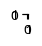

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# TODO

Get a per-peptide basis for a given clustering+ 
Correctly assigned per peptide
+ which peptides cause the incorrectly assigned


Create artificial / orthogonal distance matrix, semi-very easy task to do this
make silhouette for all datapoints in single clusters, and compare to algorithm
with artificial try a pruning before cutting?



# TCRbase detour

In [2]:
exp_swap = pd.read_csv('../data/filtered/240326_nettcr_exp_paired_withswaps.csv')
old_swap = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')

In [3]:
from sklearn.metrics import roc_auc_score
from src.metrics import get_metrics
def read_tcrbase_results(peptide, original_df, partition=0, dir='../output/TCRBASE/tcrbase_expanded_ALL_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}_p{partition}.txt', comment='#', sep='\s', header=None, names=cols)
    df['q_seq'] = df['q_A1']+df['q_A2']+df['q_A3']+df['q_B1']+df['q_B2']+df['q_B3']
    original_df = original_df.query('peptide==@peptide and partition==@partition')
    original_df['q_seq'] = original_df['A1']+original_df['A2']+original_df['A3']+original_df['B1']+original_df['B2']+original_df['B3']
    results = pd.merge(df.set_index('q_seq')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df.set_index('q_seq')[['partition','binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==@partition'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
        

In [4]:
total_exp=[]
total_old=[]
for partition in range(5):
    exp_results = []
    for p in exp_swap.peptide.unique():
        x, _ = read_tcrbase_results(p, exp_swap, partition=partition, dir='../output/TCRBASE/tcrbase_expanded_ALL_swapped/')
        exp_results.append(x)    
    exp_results = pd.DataFrame(exp_results)
    
    old_results = []
    for p in old_swap.peptide.unique():
        x, _ = read_tcrbase_results(p, old_swap, partition=partition, dir='../output/TCRBASE/tcrbase_old_ALL_swapped/')
        old_results.append(x)    
    old_results = pd.DataFrame(old_results)
    total_exp.append(exp_results.assign(partition=partition))
    total_old.append(old_results.assign(partition=partition))
    exp_results.sort_values('n_pos', ascending=False).to_csv(f'../output/TCRBASE/results_exp_partition_p{partition}.csv', index=False)
    old_results.sort_values('n_pos', ascending=False).to_csv(f'../output/TCRBASE/results_old_partition_p{partition}.csv', index=False)

AVFDRKSDAK 0.4855
{'peptide': 'AVFDRKSDAK', 'method': 'tcrbase', 'n_pos': 143, 'auc': 0.48551, 'auc_01': 0.50745, 'auc_01_real': 0.06416, 'precision': 0.16628, 'recall': 1.0, 'accuracy': 0.16628, 'AP': 0.18505}
KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 181, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 92, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}
TTDPSFLGRY 0.6819
{'peptide': 'TTDPSFLGRY', 'method': 'tcrbase', 'n_pos': 78, 'auc': 0.68187, 'auc_01': 0.61969, 'auc_01_real': 0.27741, 'precision': 0.16774, 'recall': 1.0, 'accuracy': 0.16774, 'AP': 0.44064}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 166, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recal

In [5]:
pd.concat(total_exp).drop(columns=['method']).groupby('peptide').mean().sort_values('n_pos',ascending=False).to_csv(f'../output/TCRBASE/total_mean_exp_results.csv', index=True)
pd.concat(total_old).drop(columns=['method']).groupby('peptide').mean().sort_values('n_pos',ascending=False).to_csv(f'../output/TCRBASE/total_mean_old_results.csv', index=True)

In [6]:
total_exp = pd.concat(total_exp).drop(columns=['method']).groupby('peptide').mean()
total_old = pd.concat(total_old).drop(columns=['method']).groupby('peptide').mean()

In [646]:
exp_filt = total_exp.query('n_pos>=75').sort_values('auc',ascending=False).head(17).index
total_exp.query('n_pos>75').sort_values('auc',ascending=False).head(17).sort_index()


n_pos       auc    auc_01  auc_01_real  precision  recall  \
peptide                                                                 
AVFDRKSDAK  143.4  0.537760  0.523512     0.094672   0.166668     1.0   
ELAGIGILTV   91.4  0.913552  0.809742     0.638514   0.166668     1.0   
GILGFVFTL   233.0  0.829168  0.744974     0.515450   0.166670     1.0   
KLGGALQAK   180.2  0.583082  0.561664     0.167164   0.166664     1.0   
RAKFKQLL    166.0  0.901230  0.833696     0.684024   0.166670     1.0   
SPRWYFYYL    89.8  0.671422  0.649950     0.334904   0.166670     1.0   
TTDPSFLGRY   77.4  0.672200  0.632344     0.301454   0.166666     1.0   
YLQPRTFLL    79.8  0.731442  0.694864     0.420246   0.166662     1.0   

            accuracy        AP  partition  
peptide                                    
AVFDRKSDAK  0.166668  0.216992        2.0  
ELAGIGILTV  0.166668  0.782364        2.0  
GILGFVFTL   0.166670  0.634484        2.0  
KLGGALQAK   0.166664  0.289294        2.0  
RAKFKQLL    0.166670  0.779796        2.0  
SPRWYFYYL   0.166670  0.475666        2.0  
TTDPSFLGRY  0.166666  0.458376        2.0  
YLQPRTFLL   0.166662  0.573052        2.0

# inits

In [8]:
exp_df = pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')
exp78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
exp17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
old_df = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
old15 = pd.read_csv('../data/filtered/240416_nettcr_old_top15peps_no_swaps.csv')
old20 = pd.read_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')

In [9]:
def get_agg_matrix(dm_vae, dm_base, index_col='raw_index', cols = ('peptide', 'original_peptide','raw_index', 'binder', 'partition')):
    if not all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]):
        dm_base, values_base = resort_baseline(dm_base, dm_vae, index_col)
    else:
        values_base = None
    values_vae = dm_vae.iloc[:len(dm_vae), :len(dm_vae)].values
    if values_base is None:
        values_base = dm_base.iloc[:len(dm_base), :len(dm_base)].values
    assert all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]) and len(dm_vae)==len(dm_base)
    agg_values = 1-np.multiply(1-values_vae, 1-values_base)
    agg_dm = pd.DataFrame(agg_values)
    agg_dm[list(cols)] = dm_vae[list(cols)].values
    return agg_dm, agg_dm.iloc[:len(agg_dm), :len(agg_dm)].values

In [10]:
dm_tbcr = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0)
dm_tcrdist = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0)

In [11]:
model_ts128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
model_os128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
model_os256 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/epoch_8000_interval_checkpoint__fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02_JSON_kwargs.json',
                              map_location='cpu', verbose=False)


<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 256 9 4 2 1 0 SELU()


# MST & cuts - Redo filtered runs

## Test set, Subsampled + Filtered to some peps

### Data reading and sorting

In [696]:
len(df)

639

In [695]:
import random
seed=1
random.seed(seed)
# See TCRBase detour for exp_filt
print(exp_filt)
df = exp17.query('peptide in @exp_filt and partition==1')
testset_subsample = []
for p in exp_filt:
    tmp = df.query('peptide==@p')
    testset_subsample.append(tmp.sample(min(len(tmp), random.randint(70,90)), random_state=seed))
df = pd.concat(testset_subsample)
df_idx = df['raw_index'].unique()
df.groupby('peptide').agg(count=('A1','count'))

Index(['ELAGIGILTV', 'RAKFKQLL', 'GILGFVFTL', 'YLQPRTFLL', 'TTDPSFLGRY',
       'SPRWYFYYL', 'KLGGALQAK', 'AVFDRKSDAK'],
      dtype='object', name='peptide')


count
peptide          
AVFDRKSDAK     85
ELAGIGILTV     74
GILGFVFTL      72
KLGGALQAK      84
RAKFKQLL       88
SPRWYFYYL      85
TTDPSFLGRY     73
YLQPRTFLL      78

In [618]:
# Best model picked on validation performance
latent_ts128 = get_latent_df(model_ts128, df)
latent_os128 = get_latent_df(model_os128, df)
latent_os256 = get_latent_df(model_os256, df)
dm_ts128, values_ts128, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_ts128, index_col='raw_index')
dm_os128, values_os128, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os128, index_col='raw_index')
dm_os256, values_os256, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os256, index_col='raw_index')
# Assert all index are in the same order prior to refiltering+resorting the baselines
assert all(dm_os128.raw_index == dm_os256.raw_index) and all(dm_ts128.raw_index == dm_os256.raw_index) and all(dm_ts128.raw_index == dm_os128.raw_index), 'wtf'
# re-get the baseline and re-filter based on the subset test set
dm_tbcr_testset = dm_tbcr.query('raw_index in @df_idx')
dm_tcrdist_testset = dm_tcrdist.query('raw_index in @df_idx')
# Resort it just so that we can re-use the labels and indices in the same order
dm_tbcr_testset, values_tbcr_testset = resort_baseline(dm_tbcr_testset, dm_ts128, 'raw_index')
dm_tcrdist_testset, values_tcrdist_testset = resort_baseline(dm_tcrdist_testset, dm_ts128, 'raw_index')
print(len(dm_tbcr_testset), len(dm_tcrdist_testset), len(dm_ts128), len(dm_os128), len(dm_os256))

639 639 639 639 639


In [619]:
# Aggregate the "best" model which is the two-stage 128 and the TBCRalign matrix
dm_agg, values_agg = get_agg_matrix(dm_ts128, dm_tbcr_testset)
print(len(dm_tbcr_testset), len(dm_tcrdist_testset), len(dm_ts128), len(dm_os128), len(dm_os256), len(dm_agg))

639 639 639 639 639 639


### params

In [620]:
initial_cut_threshold=1
initial_cut_method='top'
filename='240715_8peps_subsampled_partition1_test_'

### Running the algos for baselines

In [621]:
# TBCRALIGN

G, tree, dist_matrix, values_tbcr_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_tbcr_testset, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, tbcr_it_scores, tbcr_it_purities, tbcr_it_rets = iterative_size_cut(values_tbcr_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, tbcr_sh_scores, tbcr_sh_purities, tbcr_sh_rets = iterative_topn_cut(values_tbcr_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

# Running TCRdist distmatrix
G, tree, dist_matrix, values_tcrdist_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_tcrdist_testset, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, tcrdist_it_scores, tcrdist_it_purities, tcrdist_it_rets = iterative_size_cut(values_tcrdist_testset, tree, 
                                                                                                                                 initial_cut_threshold=initial_cut_threshold, 
                                                                                                                                 initial_cut_method=initial_cut_method, 
                                                                                                                                 top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, tcrdist_sh_scores, tcrdist_sh_purities, tcrdist_sh_rets = iterative_topn_cut(values_tcrdist_testset, tree, 
                                                                                                                                            initial_cut_threshold=initial_cut_threshold, 
                                                                                                                                            initial_cut_method=initial_cut_method, 
                                                                                                                                            top_n=1, which='edge', weighted=True, 
                                                                                                                                            verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

Initial mean purity, silhouette score, retention
0.193 0.0184 1.0
2.1566820276497696 2.5668202764976957
Initial mean purity, silhouette score, retention
0.1968 0.0189 1.0
2.136150234741784 2.5305164319248825


### Running for VAEs

In [622]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_ts128_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_ts128, it_purities_ts128, it_rets_ts128 = iterative_size_cut(values_ts128_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_ts128, sh_purities_ts128, sh_rets_ts128 = iterative_topn_cut(values_ts128_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


Initial mean purity, silhouette score, retention
0.2028 0.0234 1.0
2.148936170212766 2.472340425531915


In [623]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os128_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os128, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os128, it_purities_os128, it_rets_os128 = iterative_size_cut(values_os128_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os128, sh_purities_os128, sh_rets_os128 = iterative_topn_cut(values_os128_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


Initial mean purity, silhouette score, retention
0.1754 0.0177 1.0
2.0732758620689653 2.5344827586206895


In [624]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os256_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os256, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os256, it_purities_os256, it_rets_os256 = iterative_size_cut(values_os256_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os256, sh_purities_os256, sh_rets_os256 = iterative_topn_cut(values_os256_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


Initial mean purity, silhouette score, retention
0.1742 0.0184 1.0
2.2217194570135748 2.570135746606335


### Run the aggregate

In [625]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_agg_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_agg, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_agg, it_purities_agg, it_rets_agg = iterative_size_cut(values_agg_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_agg, sh_purities_agg, sh_rets_agg = iterative_topn_cut(values_agg_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


Initial mean purity, silhouette score, retention
0.2093 0.0186 1.0
2.133603238866397 2.437246963562753


In [626]:
ts128_cluster_testset = cluster_all_thresholds(values_ts128_testset, values_ts128_testset, labels, encoded_labels, label_encoder, n_jobs=8)
os128_cluster_testset = cluster_all_thresholds(values_os128_testset, values_os128_testset, labels, encoded_labels, label_encoder, n_jobs=8)
os256_cluster_testset = cluster_all_thresholds(values_os256_testset, values_os256_testset, labels, encoded_labels, label_encoder, n_jobs=8)
tcrdist_cluster_testset = cluster_all_thresholds(values_tcrdist_testset, values_tcrdist_testset, labels, encoded_labels, label_encoder, n_jobs=8)
tbcr_cluster_testset = cluster_all_thresholds(values_tbcr_testset, values_tbcr_testset, labels, encoded_labels, label_encoder, n_jobs=8)
agg_cluster_testset = cluster_all_thresholds(values_agg_testset, values_agg_testset, labels, encoded_labels, label_encoder, n_jobs=8)

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  3%|███▌                                                                                                           | 16/500 [00:05<02:32,  3.16it/s]

  5%|█████▎                                                                                                         | 24/500 [00:05<01:35,  5.00it/s]

  6%|███████                                                                                                        | 32/500 [00:05<01:05,  7.18it/s]

  8%|████████▉                                                                                                      | 40/500 [00:05<00:45, 10.09it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:06<00:36, 12.54it/s]

 11%|████████████▍                                                                          

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  3%|███▌                                                                                                          | 16/500 [00:00<00:03, 122.18it/s]

  6%|███████                                                                                                        | 32/500 [00:00<00:06, 73.47it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:00<00:10, 44.87it/s]

 13%|██████████████▏                                                                                                | 64/500 [00:01<00:10, 43.29it/s]

 16%|█████████████████▊                                                                                             | 80/500 [00:01<00:10, 41.46it/s]

 19%|█████████████████████▎                                                                 

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  6%|███████                                                                                                        | 32/500 [00:00<00:05, 90.45it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:00<00:08, 56.20it/s]

 13%|██████████████▏                                                                                                | 64/500 [00:01<00:09, 45.90it/s]

 16%|█████████████████▊                                                                                             | 80/500 [00:01<00:10, 41.63it/s]

 19%|█████████████████████▎                                                                                         | 96/500 [00:02<00:09, 41.39it/s]

 22%|████████████████████████▋                                                              

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  6%|███████                                                                                                       | 32/500 [00:00<00:04, 101.25it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:00<00:07, 62.16it/s]

 13%|██████████████▏                                                                                                | 64/500 [00:01<00:08, 50.64it/s]

 16%|█████████████████▊                                                                                             | 80/500 [00:01<00:09, 44.83it/s]

 19%|█████████████████████▎                                                                                         | 96/500 [00:01<00:08, 45.89it/s]

 22%|████████████████████████▋                                                              

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  6%|███████                                                                                                       | 32/500 [00:00<00:04, 102.32it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:00<00:06, 70.69it/s]

 13%|██████████████▏                                                                                                | 64/500 [00:01<00:08, 52.13it/s]

 16%|█████████████████▊                                                                                             | 80/500 [00:01<00:08, 47.57it/s]

 19%|█████████████████████▎                                                                                         | 96/500 [00:01<00:08, 46.39it/s]

 22%|████████████████████████▋                                                              

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  3%|███▌                                                                                                           | 16/500 [00:00<00:07, 60.97it/s]

  5%|█████▎                                                                                                         | 24/500 [00:00<00:13, 35.54it/s]

  6%|███████                                                                                                        | 32/500 [00:00<00:13, 35.63it/s]

  8%|████████▉                                                                                                      | 40/500 [00:01<00:14, 31.86it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:01<00:13, 34.62it/s]

 11%|████████████▍                                                                          

In [314]:
test_clustering = pd.concat([ts128_cluster_testset.assign(dist_matrix='ts128', method='agglomerative'), 
                                os128_cluster_testset.assign(dist_matrix='os128', method='agglomerative'), 
                                os256_cluster_testset.assign(dist_matrix='os256', method='agglomerative'), 
                                tcrdist_cluster_testset.assign(dist_matrix='tcrdist', method='agglomerative'), 
                                tbcr_cluster_testset.assign(dist_matrix='tbcr', method='agglomerative'), 
                                agg_cluster_testset.assign(dist_matrix='agg', method='agglomerative')])
test_clustering = pd.concat([test_clustering, 
           pd.concat([pd.DataFrame(np.array([sh_rets_ts128, sh_purities_ts128, sh_scores_ts128]).T, 
             columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='ts128', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_os128, sh_purities_os128, sh_scores_os128]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os128', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_os256, sh_purities_os256, sh_scores_os256]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os256', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_agg, sh_purities_agg, sh_scores_agg]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='agg', method='MST_size_cut'),
           pd.DataFrame(np.array([tbcr_sh_rets, tbcr_sh_purities, tbcr_sh_scores]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='tbcr', method='MST_size_cut'),
           pd.DataFrame(np.array([tcrdist_sh_rets, tcrdist_sh_purities, tcrdist_sh_scores]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='tcrdist', method='MST_size_cut')])]).assign(dataset='8peps', partition='test', fold=1)

### silhouette score plots

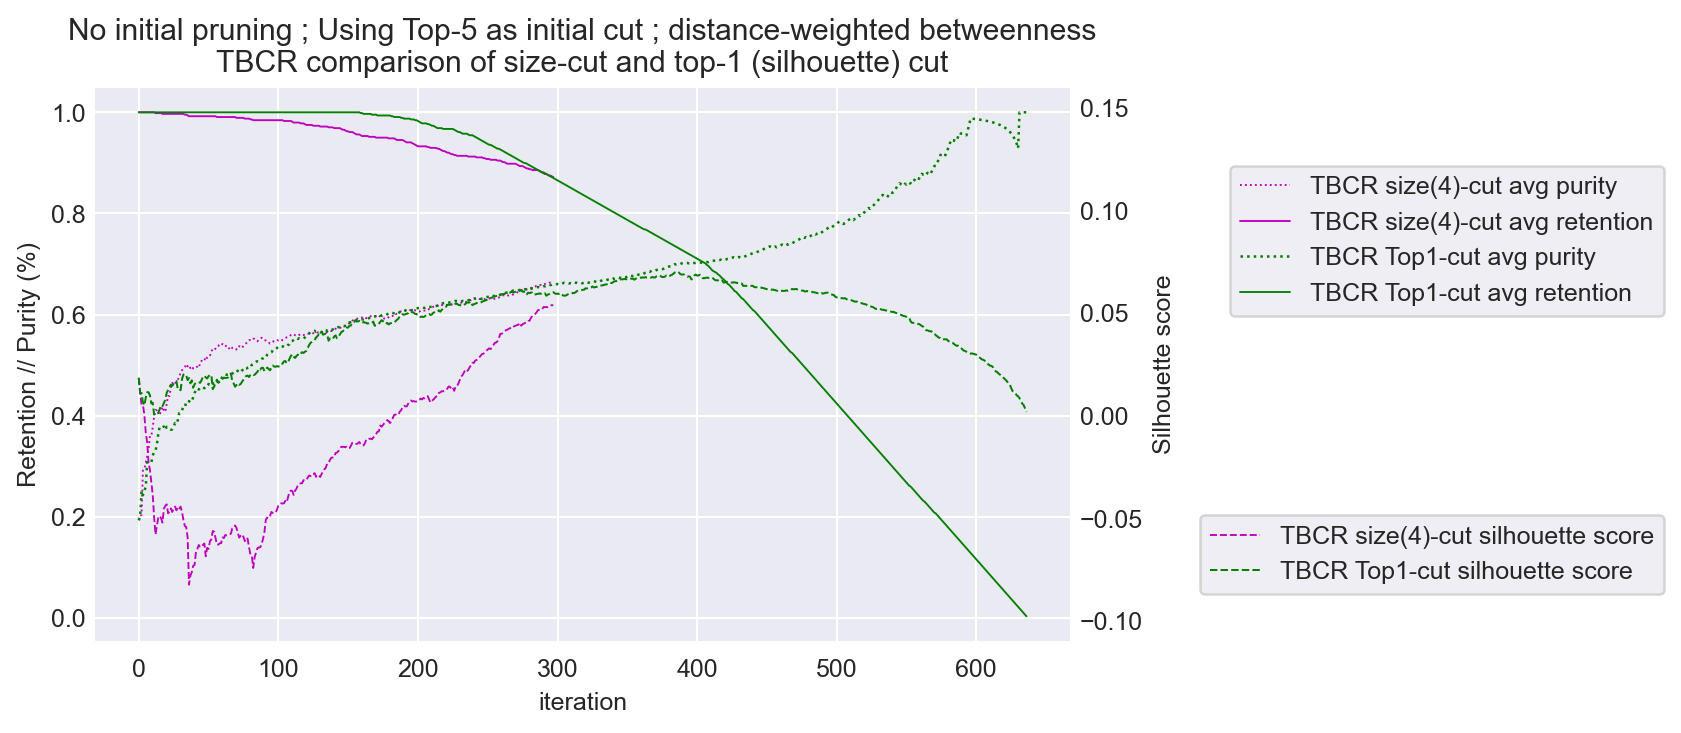

In [198]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\nTBCR comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(tbcr_it_purities)), tbcr_it_purities, lw=.75, ls=':', c='m',
       label='TBCR size(4)-cut avg purity')
a.plot(range(len(tbcr_it_rets)), tbcr_it_rets, lw=.75, ls='-', c='m',
       label='TBCR size(4)-cut avg retention')
a2.plot(range(len(tbcr_it_scores)), tbcr_it_scores, lw=.75, ls='--', c='m',
       label='TBCR size(4)-cut silhouette score')

a.plot(range(len(tbcr_sh_purities)), tbcr_sh_purities, lw=1, ls=':', c='g',
       label='TBCR Top1-cut avg purity')
a.plot(range(len(tbcr_sh_rets)), tbcr_sh_rets, lw=.75, ls='-', c='g',
       label='TBCR Top1-cut avg retention')
a2.plot(range(len(tbcr_sh_scores)), tbcr_sh_scores, lw=.8, ls='--', c='g',
       label='TBCR Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}TBCR_silhouette.png', dpi=150, bbox_inches='tight')


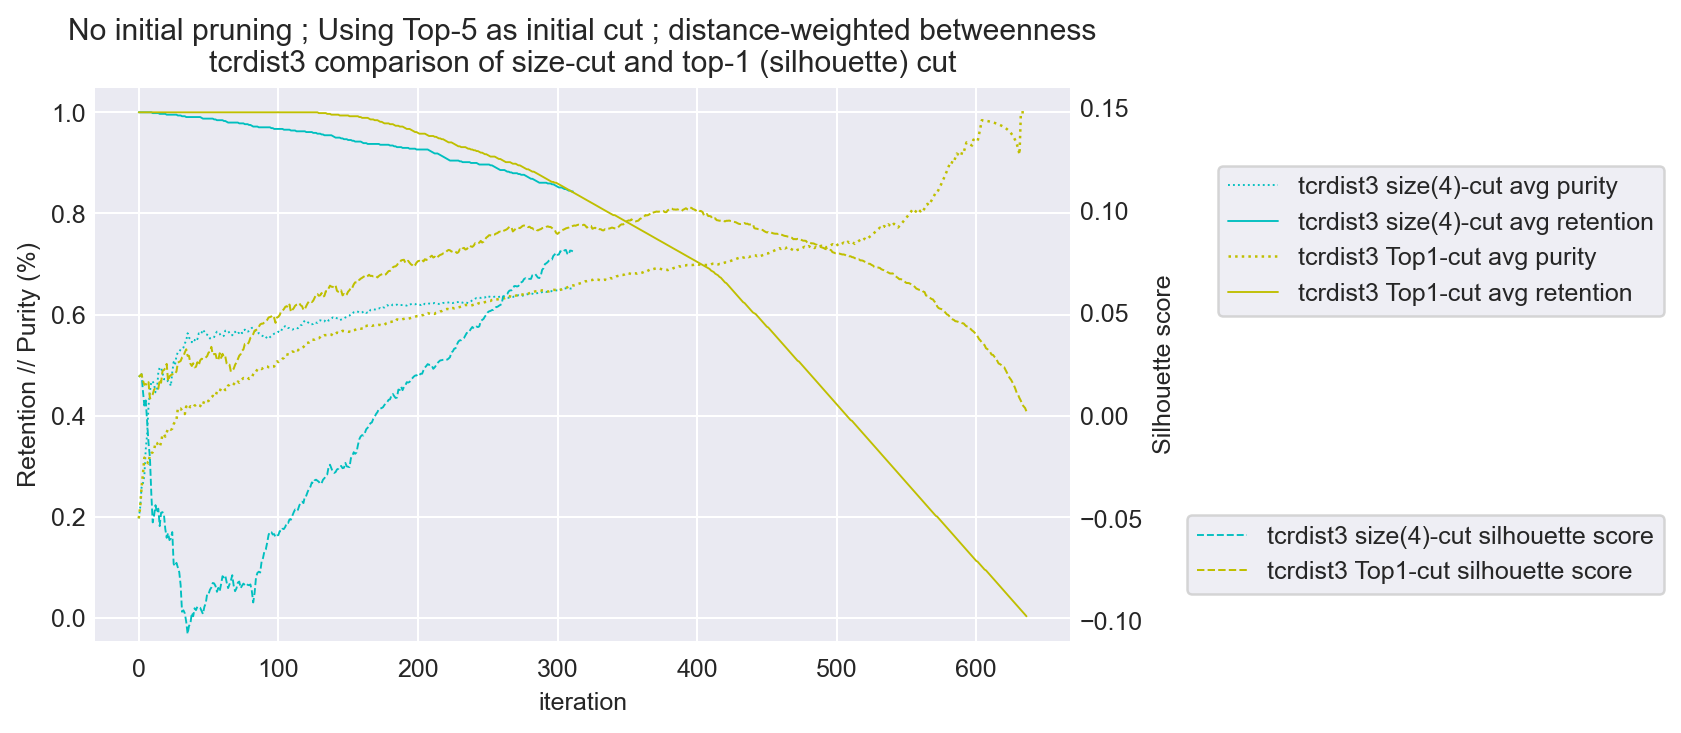

In [199]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\ntcrdist3 comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(tcrdist_it_purities)), tcrdist_it_purities, lw=.75, ls=':', c='c',
       label='tcrdist3 size(4)-cut avg purity')
a.plot(range(len(tcrdist_it_rets)), tcrdist_it_rets, lw=.75, ls='-', c='c',
       label='tcrdist3 size(4)-cut avg retention')
a2.plot(range(len(tcrdist_it_scores)), tcrdist_it_scores, lw=.75, ls='--', c='c',
       label='tcrdist3 size(4)-cut silhouette score')

a.plot(range(len(tcrdist_sh_purities)), tcrdist_sh_purities, lw=1, ls=':', c='y',
       label='tcrdist3 Top1-cut avg purity')
a.plot(range(len(tcrdist_sh_rets)), tcrdist_sh_rets, lw=.75, ls='-', c='y',
       label='tcrdist3 Top1-cut avg retention')
a2.plot(range(len(tcrdist_sh_scores)), tcrdist_sh_scores, lw=.8, ls='--', c='y',
       label='tcrdist3 Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}tcrdist3_silhouette.png', dpi=150, bbox_inches='tight')


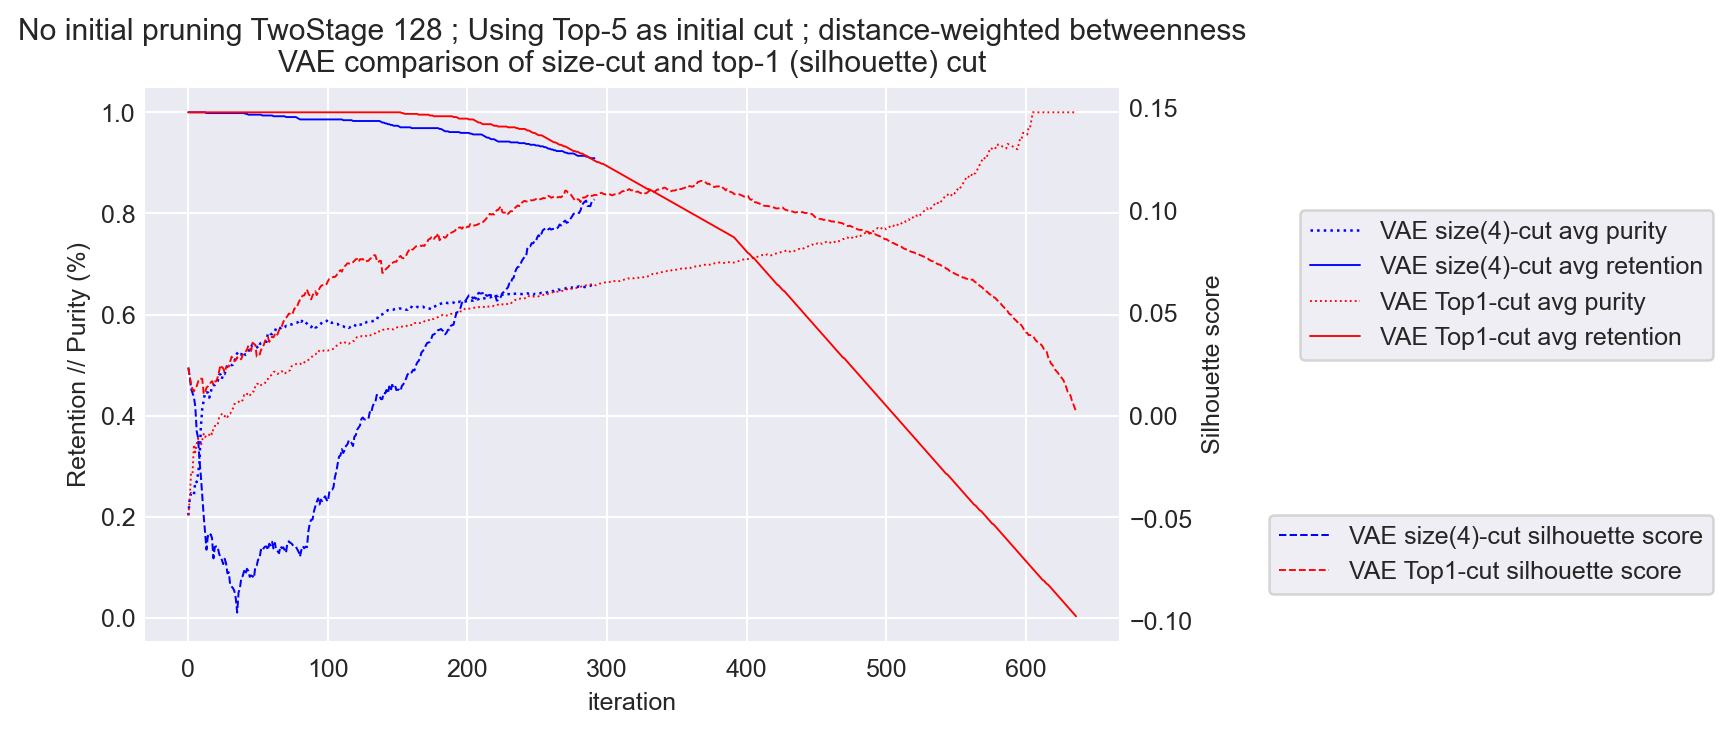

In [200]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning TwoStage 128 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_ts128)), it_purities_ts128, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_ts128)), it_rets_ts128, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_ts128)), it_scores_ts128, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_ts128)), sh_purities_ts128, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_ts128)), sh_rets_ts128, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_ts128)), sh_scores_ts128, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_ts128_silhouette.png', dpi=150, bbox_inches='tight')


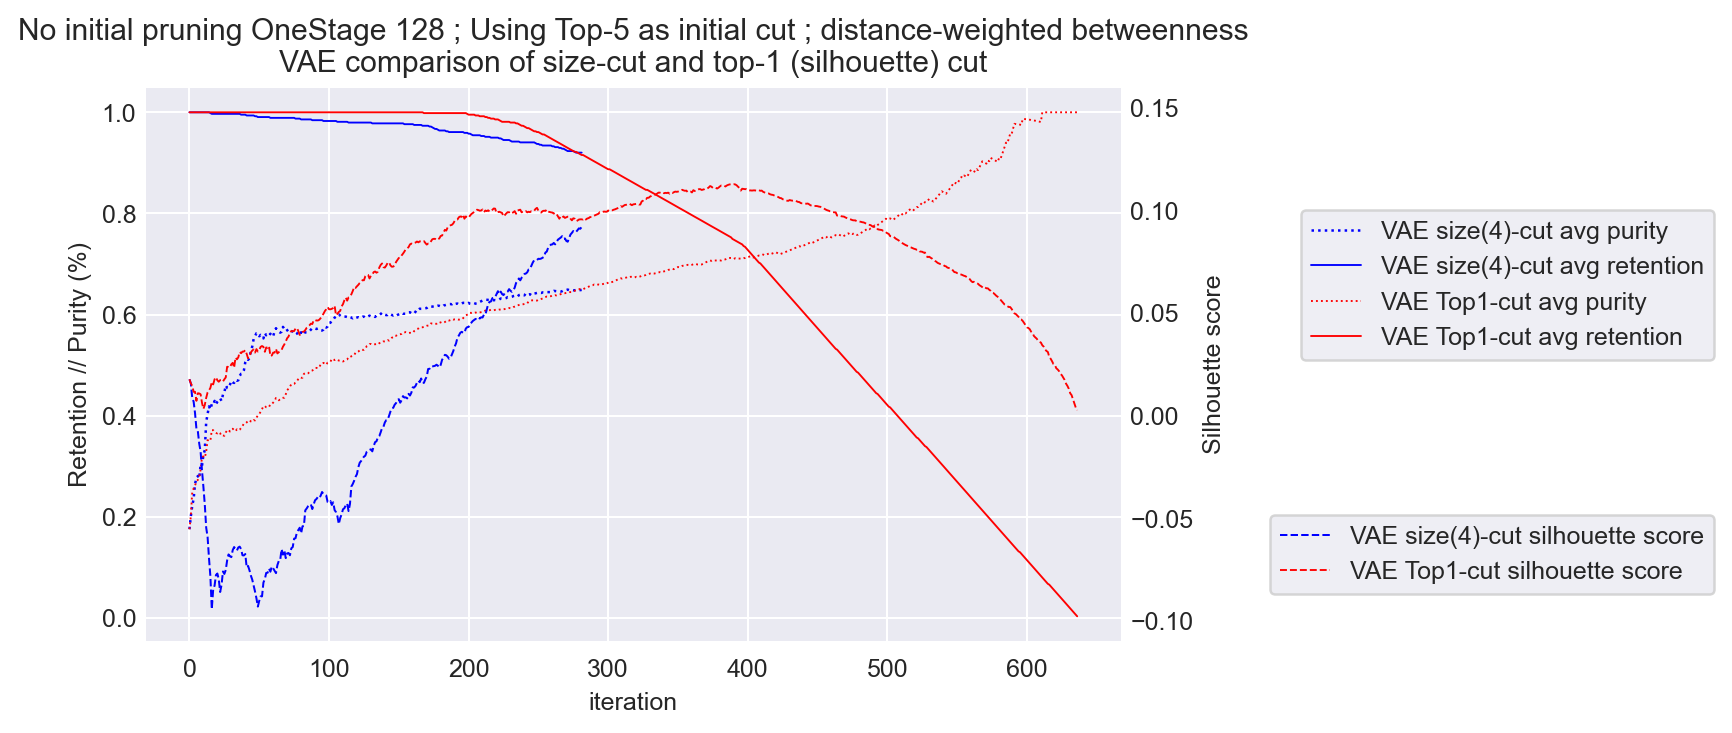

In [201]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning OneStage 128 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_os128)), it_purities_os128, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_os128)), it_rets_os128, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_os128)), it_scores_os128, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_os128)), sh_purities_os128, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_os128)), sh_rets_os128, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_os128)), sh_scores_os128, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_os128_silhouette.png', dpi=150, bbox_inches='tight')


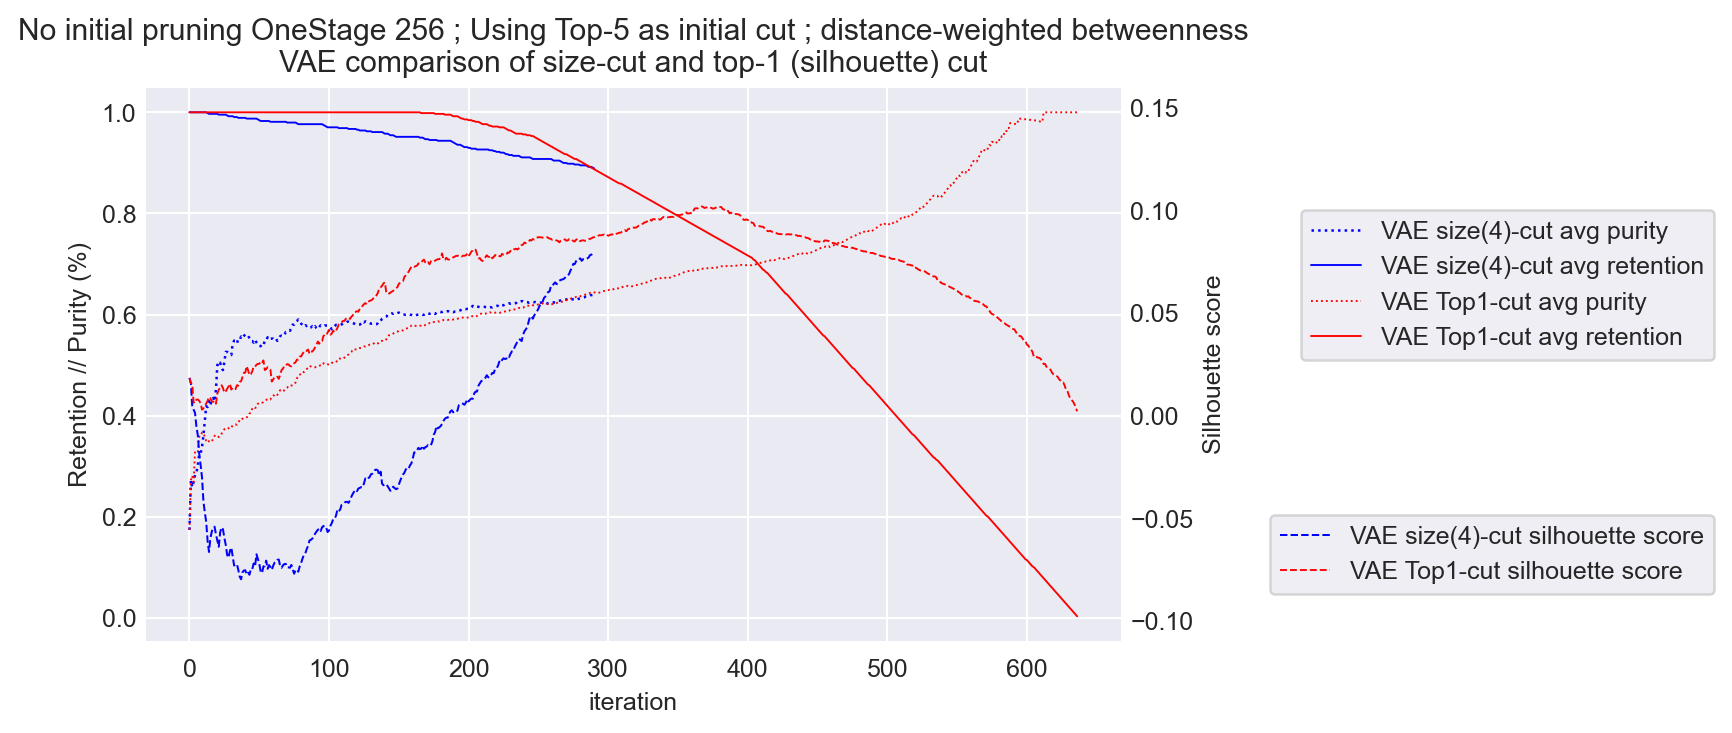

In [202]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning OneStage 256 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_os256)), it_purities_os256, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_os256)), it_rets_os256, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_os256)), it_scores_os256, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_os256)), sh_purities_os256, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_os256)), sh_rets_os256, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_os256)), sh_scores_os256, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_os256_silhouette.png', dpi=150, bbox_inches='tight')


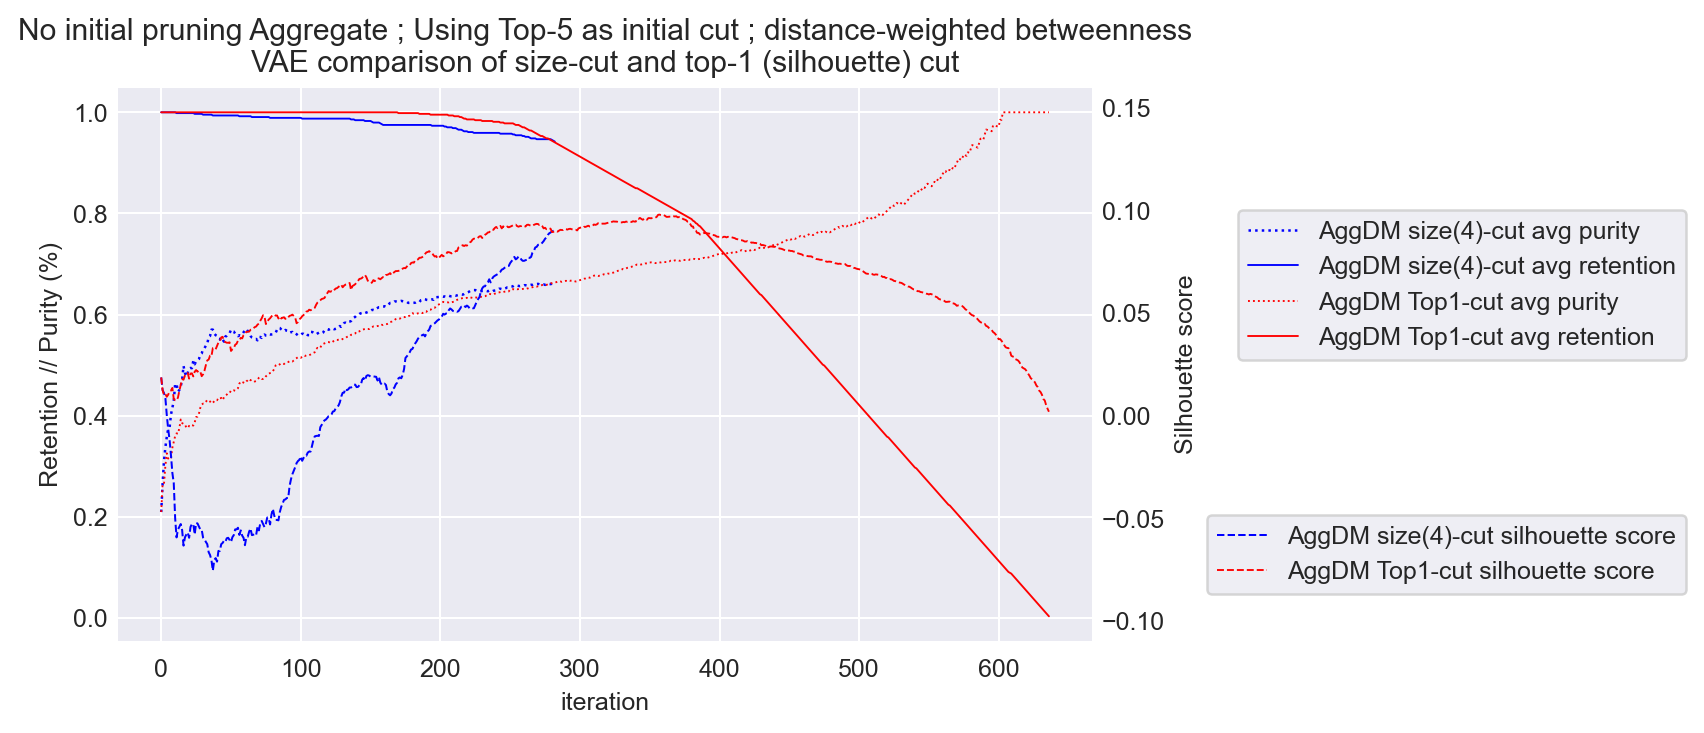

In [203]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning Aggregate ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_agg)), it_purities_agg, lw=1, ls=':', c='b',
       label='AggDM size(4)-cut avg purity')
a.plot(range(len(it_rets_agg)), it_rets_agg, lw=.75, ls='-', c='b',
       label='AggDM size(4)-cut avg retention')
a2.plot(range(len(it_scores_agg)), it_scores_agg, lw=.8, ls='--', c='b',
       label='AggDM size(4)-cut silhouette score')

a.plot(range(len(sh_purities_agg)), sh_purities_agg, lw=.75, ls=':', c='r',
       label='AggDM Top1-cut avg purity')
a.plot(range(len(sh_rets_agg)), sh_rets_agg, lw=.75, ls='-', c='r',
       label='AggDM Top1-cut avg retention')
a2.plot(range(len(sh_scores_agg)), sh_scores_agg, lw=.75, ls='--', c='r',
       label='AggDM Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_agg_silhouette.png', dpi=150, bbox_inches='tight')


### retpur curves

In [627]:
# Identify best point (based on Silhouette score) for each of the 4 conditions and add them as scatter points
best_sh_ts128 = sh_rets_ts128[np.argmax(sh_scores_ts128)], sh_purities_ts128[np.argmax(sh_scores_ts128)]
best_it_ts128 = it_rets_ts128[np.argmax(it_scores_ts128)], it_purities_ts128[np.argmax(it_scores_ts128)]
best_sh_os128 = sh_rets_os128[np.argmax(sh_scores_os128)], sh_purities_os128[np.argmax(sh_scores_os128)]
best_it_os128 = it_rets_os128[np.argmax(it_scores_os128)], it_purities_os128[np.argmax(it_scores_os128)]
best_sh_os256 = sh_rets_os256[np.argmax(sh_scores_os256)], sh_purities_os256[np.argmax(sh_scores_os256)]
best_it_os256 = it_rets_os256[np.argmax(it_scores_os256)], it_purities_os256[np.argmax(it_scores_os256)]
best_sh_agg = sh_rets_agg[np.argmax(sh_scores_agg)], sh_purities_agg[np.argmax(sh_scores_agg)]
best_it_agg = it_rets_agg[np.argmax(it_scores_agg)], it_purities_agg[np.argmax(it_scores_agg)]
best_tbcr_sh = tbcr_sh_rets[np.argmax(tbcr_sh_scores)], tbcr_sh_purities[np.argmax(tbcr_sh_scores)]
best_tbcr_it = tbcr_it_rets[np.argmax(tbcr_it_scores)], tbcr_it_purities[np.argmax(tbcr_it_scores)]
best_tcrdist_sh = tcrdist_sh_rets[np.argmax(tcrdist_sh_scores)], tcrdist_sh_purities[np.argmax(tcrdist_sh_scores)]
best_tcrdist_it = tcrdist_it_rets[np.argmax(tcrdist_it_scores)], tcrdist_it_purities[np.argmax(tcrdist_it_scores)]



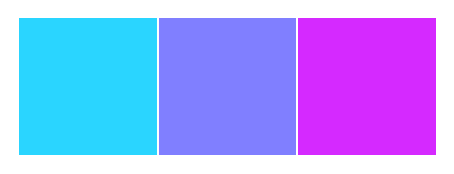

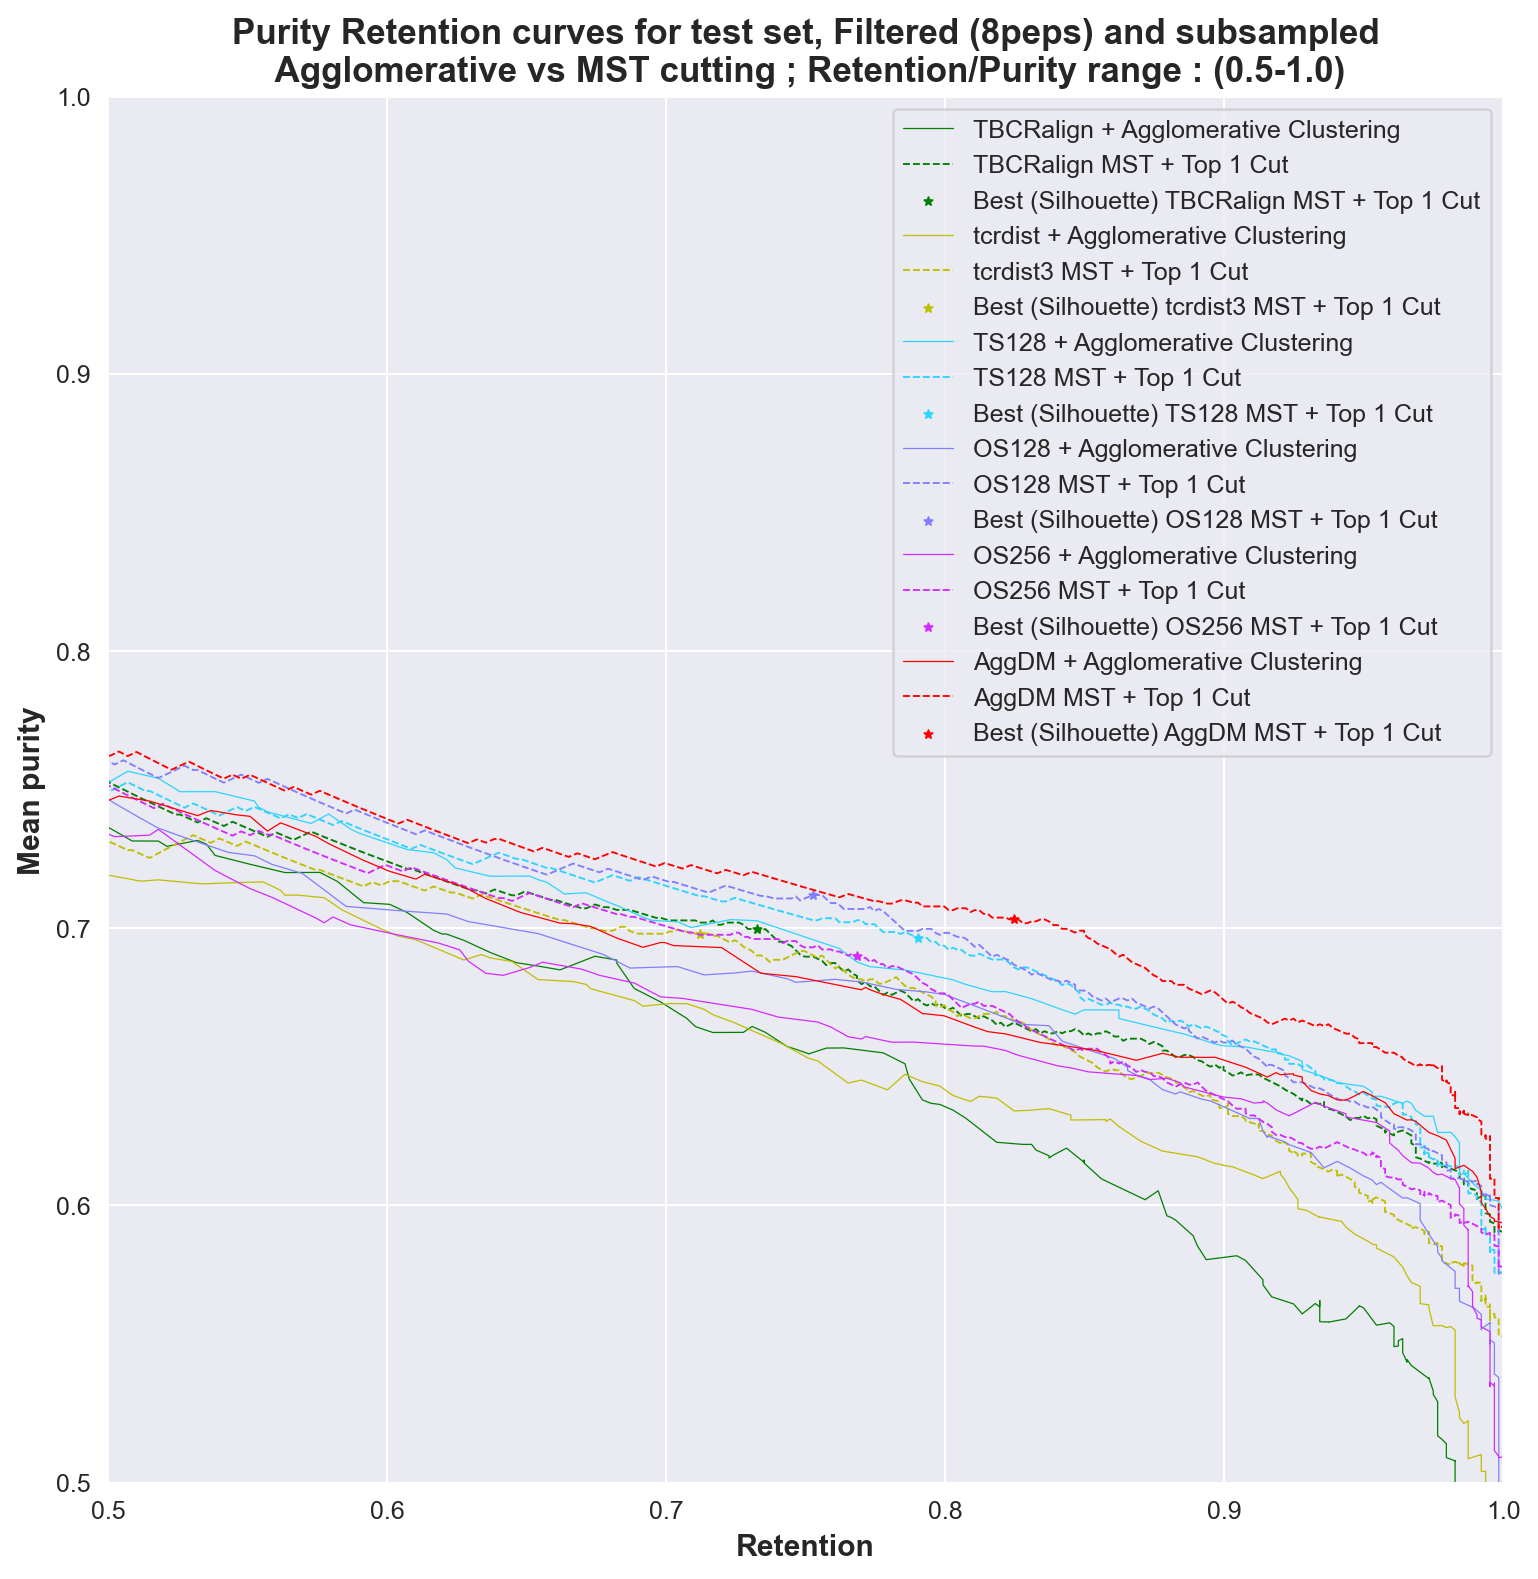

In [628]:
palette=get_palette('cool', 3)
sns.palplot(palette)
c_ts128 = palette[0]
c_os128 = palette[1]
c_os256 = palette[2]
c_agg = 'r'
c_tbcr='g'
c_tcrdist='y'
f,a = plt.subplots(1,1, figsize=(10,10))
lw=.75
marker_size=12
marker='*'
# TBCRalign
a.plot(tbcr_cluster_testset['retention'].values[1:-1], tbcr_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TBCRalign + Agglomerative Clustering', lw=0.5, ls='-', c=c_tbcr)
a.plot(tbcr_sh_rets, tbcr_sh_purities, label = 'TBCRalign MST + Top 1 Cut', lw = lw, ls='--', c=c_tbcr)
a.scatter(best_tbcr_sh[0], best_tbcr_sh[1], c=c_tbcr, label = 'Best (Silhouette) TBCRalign MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)

# tcrdist3
a.plot(tcrdist_cluster_testset['retention'].values[1:-1], tcrdist_cluster_testset['mean_purity'].values[1:-1], 
       label = 'tcrdist + Agglomerative Clustering', lw=0.5, ls='-', c=c_tcrdist)
a.plot(tcrdist_sh_rets, tcrdist_sh_purities, label = 'tcrdist3 MST + Top 1 Cut', lw = lw, ls='--', c=c_tcrdist)
a.scatter(best_tcrdist_sh[0], best_tcrdist_sh[1], c=c_tcrdist, label = 'Best (Silhouette) tcrdist3 MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)


# TS128
a.plot(ts128_cluster_testset['retention'].values[1:-1], ts128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_ts128)
a.plot(sh_rets_ts128, sh_purities_ts128, label = 'TS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_ts128)
a.scatter(best_sh_ts128[0], best_sh_ts128[1], c=c_ts128, label = 'Best (Silhouette) TS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS128
a.plot(os128_cluster_testset['retention'].values[1:-1], os128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os128)

a.plot(sh_rets_os128, sh_purities_os128, label = 'OS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_os128)
a.scatter(best_sh_os128[0], best_sh_os128[1], c=c_os128, label = 'Best (Silhouette) OS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS256
a.plot(os256_cluster_testset['retention'].values[1:-1], os256_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS256 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os256)

a.plot(sh_rets_os256, sh_purities_os256, label = 'OS256 MST + Top 1 Cut', lw = lw, ls='--', c=c_os256)
a.scatter(best_sh_os256[0], best_sh_os256[1], c=c_os256, label = 'Best (Silhouette) OS256 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# Aggregated
a.plot(agg_cluster_testset['retention'].values[1:-1], agg_cluster_testset['mean_purity'].values[1:-1], 
       label = 'AggDM + Agglomerative Clustering', lw=0.5, ls='-', c=c_agg)

a.plot(sh_rets_agg, sh_purities_agg, label = 'AggDM MST + Top 1 Cut', lw = lw, ls='--', c=c_agg)
a.scatter(best_sh_agg[0], best_sh_agg[1], c=c_agg, label = 'Best (Silhouette) AggDM MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for test set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting ; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_retpur_curves.png', dpi=200, bbox_inches='tight')

## For the test set, check per peptide correctness

In [732]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os128_testset, labels,\
    encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os128, label_col='peptide',
                                                                                 index_col='raw_index', algorithm='kruskal')

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed,\
    sh_scores_os128, sh_purities_os128, sh_rets_os128 = iterative_topn_cut(values_os128_testset, tree, 
                                                                           initial_cut_threshold=initial_cut_threshold, 
                                                                           initial_cut_method=initial_cut_method, 
                                                                           top_n=1, which='edge', weighted=True, 
                                                                           verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]),
      np.mean([x['purity'] for x in topn_clusters]), 
      np.sum([x['cluster_size'] for x in topn_clusters])/len(dm_os128))


Initial mean purity, silhouette score, retention
0.1754 0.0177 1.0
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 True
0 

In [733]:
len(nodes_removed)

158

In [734]:
len([x for x in singletons if x[0] in nodes_removed]), len(nodes_removed)

(158, 158)

In [735]:
from collections import Counter
in_clusters = [x for members in topn_clusters for x in members['members']]
singletons = [x for x in tree.nodes(data=True) if x[0] not in in_clusters]
my_list = [x[1]['peptide'] for x in singletons]
occurrences = Counter(my_list)
print(occurrences)

Counter({'SPRWYFYYL': 31, 'AVFDRKSDAK': 25, 'KLGGALQAK': 23, 'GILGFVFTL': 19, 'ELAGIGILTV': 17, 'RAKFKQLL': 17, 'TTDPSFLGRY': 14, 'YLQPRTFLL': 12})


In [638]:
cluster_df = pd.DataFrame(topn_clusters)
cluster_df

cluster_size majority_label    purity                             counts  \
0               3      GILGFVFTL  0.666667  {'ELAGIGILTV': 1, 'GILGFVFTL': 2}   
1               3       RAKFKQLL  1.000000                    {'RAKFKQLL': 3}   
2               3       RAKFKQLL  1.000000                    {'RAKFKQLL': 3}   
3               3       RAKFKQLL  1.000000                    {'RAKFKQLL': 3}   
4               3       RAKFKQLL  0.666667   {'AVFDRKSDAK': 1, 'RAKFKQLL': 2}   
..            ...            ...       ...                                ...   
227             2     AVFDRKSDAK  0.500000  {'AVFDRKSDAK': 1, 'KLGGALQAK': 1}   
228             2     AVFDRKSDAK  1.000000                  {'AVFDRKSDAK': 2}   
229             2     AVFDRKSDAK  1.000000                  {'AVFDRKSDAK': 2}   
230             2     AVFDRKSDAK  1.000000                  {'AVFDRKSDAK': 2}   
231             2     AVFDRKSDAK  1.000000                  {'AVFDRKSDAK': 2}   

             members  
0     {25, 228, 197}  
1     {161, 139, 79}  
2     {138, 123, 84}  
3    {104, 145, 119}  
4    {105, 116, 597}  
..               ...  
227       {552, 585}  
228       {629, 559}  
229       {562, 581}  
230       {624, 564}  
231       {593, 567}  

[232 rows x 5 columns]

In [645]:
cluster_df.groupby(['majority_label']).agg(mean_purity=('purity','mean'), 
                                           mean_size=('cluster_size','mean'),
                                           n_clusters=('cluster_size','count'), )

mean_purity  mean_size  n_clusters
majority_label                                    
AVFDRKSDAK         0.537037   2.000000          54
ELAGIGILTV         0.720588   2.000000          34
GILGFVFTL          0.759259   2.222222          27
KLGGALQAK          0.644737   2.000000          38
RAKFKQLL           0.822222   2.166667          30
SPRWYFYYL          0.727273   2.000000          22
TTDPSFLGRY         0.916667   2.083333          12
YLQPRTFLL          1.000000   2.333333          15

In [641]:
cluster_df.query('cluster_size==3')

cluster_size majority_label    purity                             counts  \
0              3      GILGFVFTL  0.666667  {'ELAGIGILTV': 1, 'GILGFVFTL': 2}   
1              3       RAKFKQLL  1.000000                    {'RAKFKQLL': 3}   
2              3       RAKFKQLL  1.000000                    {'RAKFKQLL': 3}   
3              3       RAKFKQLL  1.000000                    {'RAKFKQLL': 3}   
4              3       RAKFKQLL  0.666667   {'AVFDRKSDAK': 1, 'RAKFKQLL': 2}   
5              3       RAKFKQLL  1.000000                    {'RAKFKQLL': 3}   
6              3      GILGFVFTL  0.666667   {'GILGFVFTL': 2, 'SPRWYFYYL': 1}   
7              3      GILGFVFTL  0.666667  {'AVFDRKSDAK': 1, 'GILGFVFTL': 2}   
8              3      GILGFVFTL  1.000000                   {'GILGFVFTL': 3}   
9              3      GILGFVFTL  1.000000                   {'GILGFVFTL': 3}   
10             3      GILGFVFTL  1.000000                   {'GILGFVFTL': 3}   
11             3      YLQPRTFLL  1.000000                   {'YLQPRTFLL': 3}   
12             3      YLQPRTFLL  1.000000                   {'YLQPRTFLL': 3}   
13             3      YLQPRTFLL  1.000000                   {'YLQPRTFLL': 3}   
14             3      YLQPRTFLL  1.000000                   {'YLQPRTFLL': 3}   
15             3      YLQPRTFLL  1.000000                   {'YLQPRTFLL': 3}   
16             3     TTDPSFLGRY  1.000000                  {'TTDPSFLGRY': 3}   

            members  
0    {25, 228, 197}  
1    {161, 139, 79}  
2    {138, 123, 84}  
3   {104, 145, 119}  
4   {105, 116, 597}  
5   {125, 126, 111}  
6   {208, 426, 174}  
7   {177, 583, 215}  
8   {188, 214, 182}  
9   {184, 233, 206}  
10  {217, 219, 229}  
11  {236, 310, 246}  
12  {256, 273, 238}  
13  {283, 244, 239}  
14  {291, 243, 255}  
15  {266, 282, 286}  
16  {373, 372, 333}

In [637]:
pd.DataFrame(topn_clusters).query('purity<0.6').counts.values

array([{'ELAGIGILTV': 1, 'RAKFKQLL': 1},
       {'ELAGIGILTV': 1, 'GILGFVFTL': 1},
       {'ELAGIGILTV': 1, 'YLQPRTFLL': 1},
       {'AVFDRKSDAK': 1, 'ELAGIGILTV': 1},
       {'AVFDRKSDAK': 1, 'ELAGIGILTV': 1},
       {'AVFDRKSDAK': 1, 'ELAGIGILTV': 1},
       {'ELAGIGILTV': 1, 'SPRWYFYYL': 1},
       {'ELAGIGILTV': 1, 'YLQPRTFLL': 1},
       {'AVFDRKSDAK': 1, 'ELAGIGILTV': 1},
       {'ELAGIGILTV': 1, 'TTDPSFLGRY': 1},
       {'ELAGIGILTV': 1, 'YLQPRTFLL': 1},
       {'ELAGIGILTV': 1, 'SPRWYFYYL': 1},
       {'ELAGIGILTV': 1, 'RAKFKQLL': 1},
       {'ELAGIGILTV': 1, 'SPRWYFYYL': 1},
       {'ELAGIGILTV': 1, 'GILGFVFTL': 1},
       {'AVFDRKSDAK': 1, 'ELAGIGILTV': 1},
       {'ELAGIGILTV': 1, 'SPRWYFYYL': 1},
       {'AVFDRKSDAK': 1, 'ELAGIGILTV': 1},
       {'ELAGIGILTV': 1, 'RAKFKQLL': 1},
       {'AVFDRKSDAK': 1, 'ELAGIGILTV': 1},
       {'ELAGIGILTV': 1, 'GILGFVFTL': 1},
       {'ELAGIGILTV': 1, 'RAKFKQLL': 1},
       {'ELAGIGILTV': 1, 'TTDPSFLGRY': 1},
       {'ELAGIGILTV': 1, 'SPR

## Valid set, Subsampled + Filtered to some peps

### Data reading and sorting

In [315]:
import random
seed=1
random.seed(seed)
# See TCRBase detour for exp_filt
print(exp_filt)
df = exp17.query('peptide in @exp_filt and partition==0')
testset_subsample = []
for p in exp_filt:
    tmp = df.query('peptide==@p')
    testset_subsample.append(tmp.sample(min(len(tmp), random.randint(70,90)), random_state=seed))
df = pd.concat(testset_subsample)
df_idx = df['raw_index'].unique()
df.groupby('peptide').count()

Index(['ELAGIGILTV', 'RAKFKQLL', 'GILGFVFTL', 'YLQPRTFLL', 'TTDPSFLGRY',
       'SPRWYFYYL', 'KLGGALQAK', 'AVFDRKSDAK'],
      dtype='object', name='peptide')


Unnamed: 0.1  Unnamed: 0  A1  A2  A3  B1  B2  B3  allele  \
peptide                                                                
AVFDRKSDAK            85          85  85  85  85  85  85  85      85   
ELAGIGILTV            74          74  74  74  74  74  74  74      74   
GILGFVFTL             72          72  72  72  72  72  72  72      72   
KLGGALQAK             84          84  84  84  84  84  84  84      84   
RAKFKQLL              88          88  88  88  88  88  88  88      88   
SPRWYFYYL             85          85  85  85  85  85  85  85      85   
TTDPSFLGRY            73          73  73  73  73  73  73  73      73   
YLQPRTFLL             78          78  78  78  78  78  78  78      78   

            partition  binder  origin  original_peptide  raw_index  reference  \
peptide                                                                         
AVFDRKSDAK         85      85      85                85         85         85   
ELAGIGILTV         74      74      74                74         74         74   
GILGFVFTL          72      72      72                72         72         72   
KLGGALQAK          84      84      84                84         84         84   
RAKFKQLL           88      88      88                88         88         88   
SPRWYFYYL          85      85      85                85         85         85   
TTDPSFLGRY         73      73      73                73         73         73   
YLQPRTFLL          78      78      78                78         78         78   

            source_organism  input_type  db  
peptide                                      
AVFDRKSDAK                0          85  85  
ELAGIGILTV                6          74  74  
GILGFVFTL                26          72  72  
KLGGALQAK                 0          84  84  
RAKFKQLL                  0          88  88  
SPRWYFYYL                85          85  85  
TTDPSFLGRY               73          73  73  
YLQPRTFLL                78          78  78

In [316]:
# Best model picked on validation performance
latent_ts128 = get_latent_df(model_ts128, df)
latent_os128 = get_latent_df(model_os128, df)
latent_os256 = get_latent_df(model_os256, df)
dm_ts128, values_ts128, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_ts128, index_col='raw_index')
dm_os128, values_os128, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os128, index_col='raw_index')
dm_os256, values_os256, feats, labels, enc_labels, lab_enc = get_distances_labels_from_latent(latent_os256, index_col='raw_index')
# Assert all index are in the same order prior to refiltering+resorting the baselines
assert all(dm_os128.raw_index == dm_os256.raw_index) and all(dm_ts128.raw_index == dm_os256.raw_index) and all(dm_ts128.raw_index == dm_os128.raw_index), 'wtf'
# re-get the baseline and re-filter based on the subset test set
dm_tbcr_testset = dm_tbcr.query('raw_index in @df_idx')
dm_tcrdist_testset = dm_tcrdist.query('raw_index in @df_idx')
# Resort it just so that we can re-use the labels and indices in the same order
dm_tbcr_testset, values_tbcr_testset = resort_baseline(dm_tbcr_testset, dm_ts128, 'raw_index')
dm_tcrdist_testset, values_tcrdist_testset = resort_baseline(dm_tcrdist_testset, dm_ts128, 'raw_index')
print(len(dm_tbcr_testset), len(dm_tcrdist_testset), len(dm_ts128), len(dm_os128), len(dm_os256))

639 639 639 639 639


In [317]:
# Aggregate the "best" model which is the two-stage 128 and the TBCRalign matrix
dm_agg, values_agg = get_agg_matrix(dm_ts128, dm_tbcr_testset)
print(len(dm_tbcr_testset), len(dm_tcrdist_testset), len(dm_ts128), len(dm_os128), len(dm_os256), len(dm_agg))

639 639 639 639 639 639


### params

In [318]:
initial_cut_threshold=1
initial_cut_method='top'
filename='240715_8peps_subsampled_partition0_validation_'

### Running the algos for baselines

In [319]:
# TBCRALIGN

G, tree, dist_matrix, values_tbcr_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_tbcr_testset, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, tbcr_it_scores, tbcr_it_purities, tbcr_it_rets = iterative_size_cut(values_tbcr_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, tbcr_sh_scores, tbcr_sh_purities, tbcr_sh_rets = iterative_topn_cut(values_tbcr_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

# Running TCRdist distmatrix
G, tree, dist_matrix, values_tcrdist_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_tcrdist_testset, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, tcrdist_it_scores, tcrdist_it_purities, tcrdist_it_rets = iterative_size_cut(values_tcrdist_testset, tree, 
                                                                                                                                 initial_cut_threshold=initial_cut_threshold, 
                                                                                                                                 initial_cut_method=initial_cut_method, 
                                                                                                                                 top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, tcrdist_sh_scores, tcrdist_sh_purities, tcrdist_sh_rets = iterative_topn_cut(values_tcrdist_testset, tree, 
                                                                                                                                            initial_cut_threshold=initial_cut_threshold, 
                                                                                                                                            initial_cut_method=initial_cut_method, 
                                                                                                                                            top_n=1, which='edge', weighted=True, 
                                                                                                                                            verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

Initial mean purity, silhouette score, retention
0.2024 0.0198 1.0
2.2 2.4695652173913043
Initial mean purity, silhouette score, retention
0.1991 0.0174 1.0
2.108695652173913 2.465217391304348


### Running for VAEs

In [320]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_ts128_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_ts128, it_purities_ts128, it_rets_ts128 = iterative_size_cut(values_ts128_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_ts128, sh_purities_ts128, sh_rets_ts128 = iterative_topn_cut(values_ts128_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


Initial mean purity, silhouette score, retention
0.2319 0.0292 1.0
2.168724279835391 2.44672131147541


In [321]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os128_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os128, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os128, it_purities_os128, it_rets_os128 = iterative_size_cut(values_os128_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os128, sh_purities_os128, sh_rets_os128 = iterative_topn_cut(values_os128_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


Initial mean purity, silhouette score, retention
0.2128 0.0216 1.0
2.2532751091703056 2.5


In [322]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_os256_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_os256, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_os256, it_purities_os256, it_rets_os256 = iterative_size_cut(values_os256_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_os256, sh_purities_os256, sh_rets_os256 = iterative_topn_cut(values_os256_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


Initial mean purity, silhouette score, retention
0.2063 0.0212 1.0
2.157446808510638 2.4915254237288136


### Run the aggregate

In [323]:
# One-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G, tree, dist_matrix, values_agg_testset, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_agg, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, it_scores_agg, it_purities_agg, it_rets_agg = iterative_size_cut(values_agg_testset, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, sh_scores_agg, sh_purities_agg, sh_rets_agg = iterative_topn_cut(values_agg_testset, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))


Initial mean purity, silhouette score, retention
0.2348 0.0253 1.0
2.103305785123967 2.45679012345679


In [324]:
ts128_cluster_testset = cluster_all_thresholds(values_ts128_testset, values_ts128_testset, labels, encoded_labels, label_encoder, n_jobs=8)
os128_cluster_testset = cluster_all_thresholds(values_os128_testset, values_os128_testset, labels, encoded_labels, label_encoder, n_jobs=8)
os256_cluster_testset = cluster_all_thresholds(values_os256_testset, values_os256_testset, labels, encoded_labels, label_encoder, n_jobs=8)
tcrdist_cluster_testset = cluster_all_thresholds(values_tcrdist_testset, values_tcrdist_testset, labels, encoded_labels, label_encoder, n_jobs=8)
tbcr_cluster_testset = cluster_all_thresholds(values_tbcr_testset, values_tbcr_testset, labels, encoded_labels, label_encoder, n_jobs=8)
agg_cluster_testset = cluster_all_thresholds(values_agg_testset, values_agg_testset, labels, encoded_labels, label_encoder, n_jobs=8)

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  3%|███▌                                                                                                           | 16/500 [00:00<00:08, 54.60it/s]

  5%|█████▎                                                                                                         | 24/500 [00:00<00:17, 27.32it/s]

  6%|███████                                                                                                        | 32/500 [00:01<00:15, 30.74it/s]

  8%|████████▉                                                                                                      | 40/500 [00:01<00:14, 31.36it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:01<00:14, 32.25it/s]

 11%|████████████▍                                                                          

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  3%|███▌                                                                                                           | 16/500 [00:00<00:05, 82.68it/s]

  6%|███████                                                                                                        | 32/500 [00:00<00:05, 87.20it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:00<00:08, 53.24it/s]

 13%|██████████████▏                                                                                                | 64/500 [00:01<00:09, 44.87it/s]

 16%|█████████████████▊                                                                                             | 80/500 [00:01<00:10, 40.49it/s]

 19%|█████████████████████▎                                                                 

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  3%|███▌                                                                                                          | 16/500 [00:00<00:03, 134.85it/s]

  6%|███████                                                                                                        | 32/500 [00:00<00:06, 67.54it/s]

  8%|█████████                                                                                                      | 41/500 [00:00<00:06, 71.59it/s]

 10%|███████████                                                                                                    | 50/500 [00:00<00:10, 41.54it/s]

 13%|██████████████▏                                                                                                | 64/500 [00:01<00:12, 36.22it/s]

 16%|█████████████████▊                                                                     

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  6%|███████                                                                                                        | 32/500 [00:00<00:05, 87.04it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:00<00:08, 52.77it/s]

 13%|██████████████▏                                                                                                | 64/500 [00:01<00:10, 41.38it/s]

 16%|█████████████████▊                                                                                             | 80/500 [00:01<00:11, 35.17it/s]

 19%|█████████████████████▎                                                                                         | 96/500 [00:02<00:12, 32.94it/s]

 22%|████████████████████████▋                                                              

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  3%|███▌                                                                                                           | 16/500 [00:00<00:05, 82.06it/s]

  6%|███████                                                                                                        | 32/500 [00:00<00:09, 51.88it/s]

 10%|██████████▋                                                                                                    | 48/500 [00:00<00:09, 46.62it/s]

 13%|██████████████▏                                                                                                | 64/500 [00:01<00:10, 41.10it/s]

 16%|█████████████████▊                                                                                             | 80/500 [00:01<00:11, 37.54it/s]

 19%|█████████████████████▎                                                                 

HERE




  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]

  3%|███▌                                                                                                           | 16/500 [00:00<00:08, 54.00it/s]

  4%|████▉                                                                                                          | 22/500 [00:00<00:08, 55.36it/s]

  6%|██████▏                                                                                                        | 28/500 [00:00<00:14, 32.35it/s]

  6%|███████                                                                                                        | 32/500 [00:01<00:19, 24.46it/s]

  8%|████████▉                                                                                                      | 40/500 [00:01<00:18, 24.65it/s]

 10%|██████████▋                                                                            

In [325]:
valid_clustering = pd.concat([ts128_cluster_testset.assign(dist_matrix='ts128', method='agglomerative'), 
                                os128_cluster_testset.assign(dist_matrix='os128', method='agglomerative'), 
                                os256_cluster_testset.assign(dist_matrix='os256', method='agglomerative'), 
                                tcrdist_cluster_testset.assign(dist_matrix='tcrdist', method='agglomerative'), 
                                tbcr_cluster_testset.assign(dist_matrix='tbcr', method='agglomerative'), 
                                agg_cluster_testset.assign(dist_matrix='agg', method='agglomerative')])
valid_clustering = pd.concat([valid_clustering, 
           pd.concat([pd.DataFrame(np.array([sh_rets_ts128, sh_purities_ts128, sh_scores_ts128]).T, 
             columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='ts128', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_os128, sh_purities_os128, sh_scores_os128]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os128', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_os256, sh_purities_os256, sh_scores_os256]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='os256', method='MST_size_cut'),
           pd.DataFrame(np.array([sh_rets_agg, sh_purities_agg, sh_scores_agg]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='agg', method='MST_size_cut'),
           pd.DataFrame(np.array([tbcr_sh_rets, tbcr_sh_purities, tbcr_sh_scores]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='tbcr', method='MST_size_cut'),
           pd.DataFrame(np.array([tcrdist_sh_rets, tcrdist_sh_purities, tcrdist_sh_scores]).T, 
                        columns = ['retention', 'mean_purity', 'silhouette']).assign(dist_matrix='tcrdist', method='MST_size_cut')])]).assign(dataset='8peps', partition='valid', fold=0)

### silhouette score plots

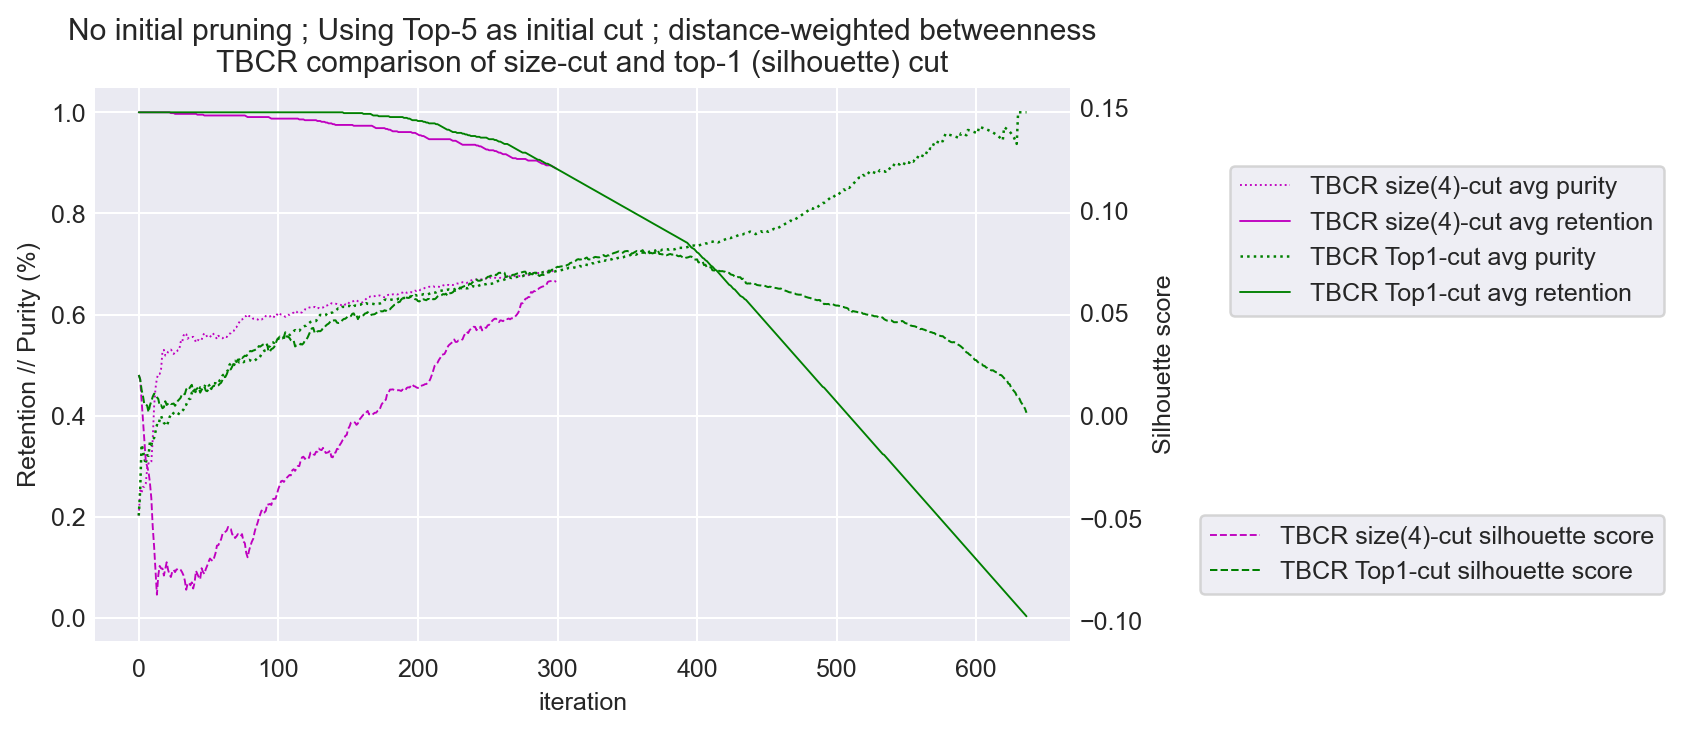

In [217]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\nTBCR comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(tbcr_it_purities)), tbcr_it_purities, lw=.75, ls=':', c='m',
       label='TBCR size(4)-cut avg purity')
a.plot(range(len(tbcr_it_rets)), tbcr_it_rets, lw=.75, ls='-', c='m',
       label='TBCR size(4)-cut avg retention')
a2.plot(range(len(tbcr_it_scores)), tbcr_it_scores, lw=.75, ls='--', c='m',
       label='TBCR size(4)-cut silhouette score')

a.plot(range(len(tbcr_sh_purities)), tbcr_sh_purities, lw=1, ls=':', c='g',
       label='TBCR Top1-cut avg purity')
a.plot(range(len(tbcr_sh_rets)), tbcr_sh_rets, lw=.75, ls='-', c='g',
       label='TBCR Top1-cut avg retention')
a2.plot(range(len(tbcr_sh_scores)), tbcr_sh_scores, lw=.8, ls='--', c='g',
       label='TBCR Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}TBCR_silhouette.png', dpi=150, bbox_inches='tight')


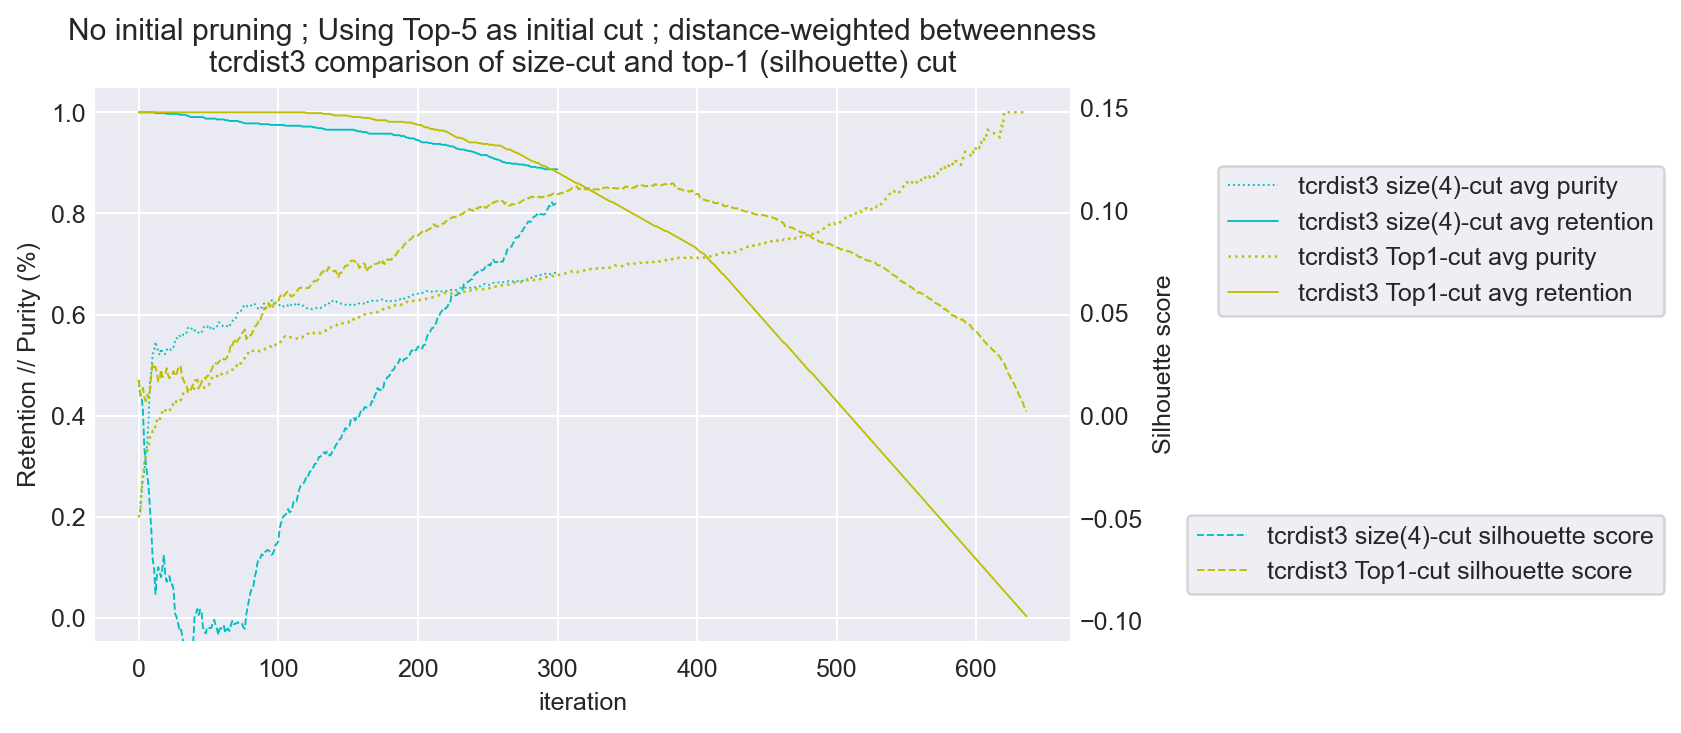

In [218]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\ntcrdist3 comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(tcrdist_it_purities)), tcrdist_it_purities, lw=.75, ls=':', c='c',
       label='tcrdist3 size(4)-cut avg purity')
a.plot(range(len(tcrdist_it_rets)), tcrdist_it_rets, lw=.75, ls='-', c='c',
       label='tcrdist3 size(4)-cut avg retention')
a2.plot(range(len(tcrdist_it_scores)), tcrdist_it_scores, lw=.75, ls='--', c='c',
       label='tcrdist3 size(4)-cut silhouette score')

a.plot(range(len(tcrdist_sh_purities)), tcrdist_sh_purities, lw=1, ls=':', c='y',
       label='tcrdist3 Top1-cut avg purity')
a.plot(range(len(tcrdist_sh_rets)), tcrdist_sh_rets, lw=.75, ls='-', c='y',
       label='tcrdist3 Top1-cut avg retention')
a2.plot(range(len(tcrdist_sh_scores)), tcrdist_sh_scores, lw=.8, ls='--', c='y',
       label='tcrdist3 Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}tcrdist3_silhouette.png', dpi=150, bbox_inches='tight')


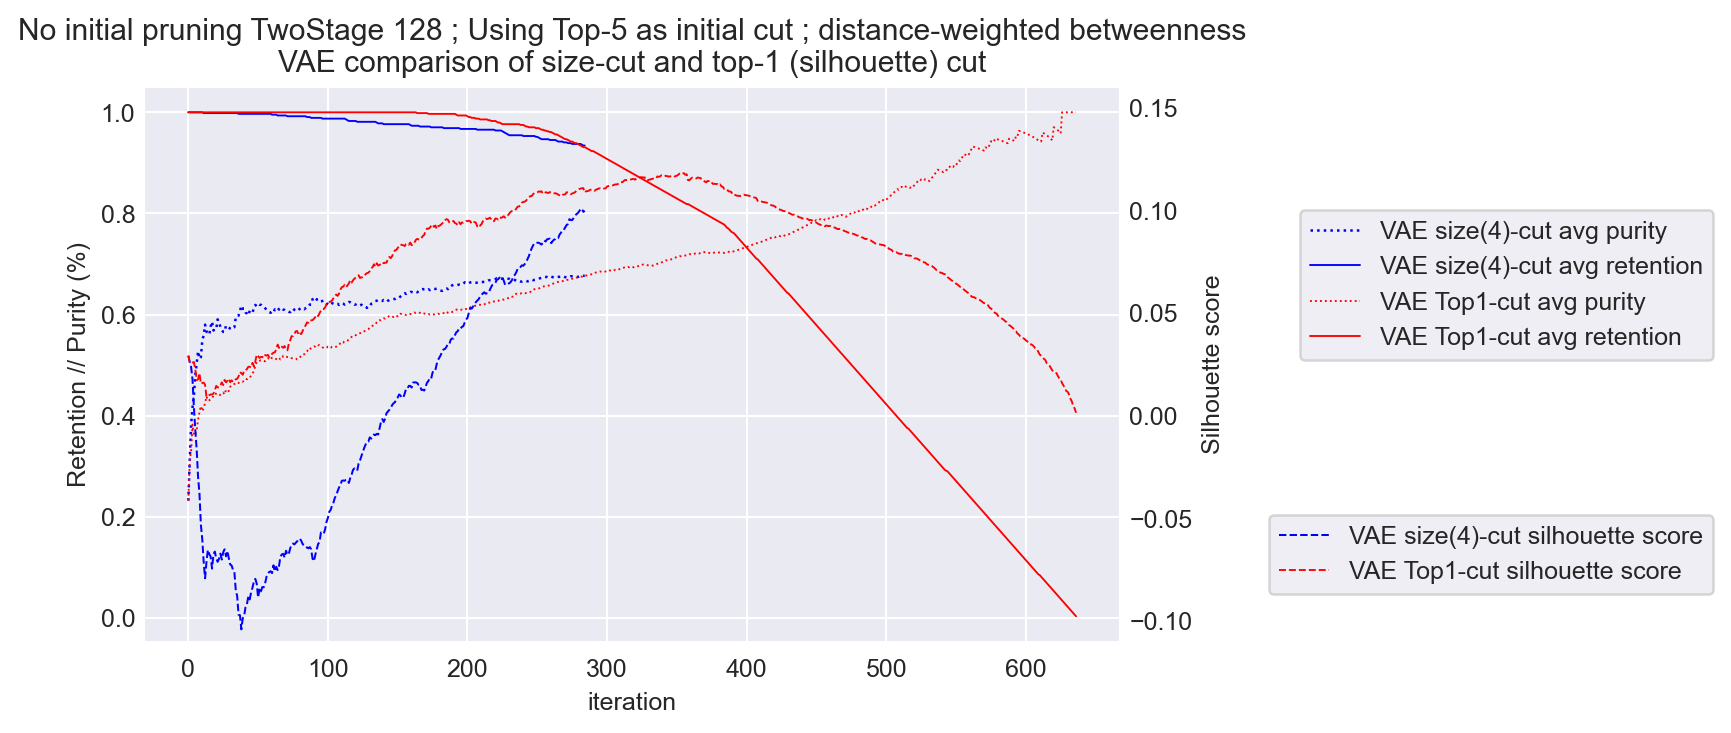

In [219]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning TwoStage 128 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_ts128)), it_purities_ts128, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_ts128)), it_rets_ts128, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_ts128)), it_scores_ts128, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_ts128)), sh_purities_ts128, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_ts128)), sh_rets_ts128, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_ts128)), sh_scores_ts128, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_ts128_silhouette.png', dpi=150, bbox_inches='tight')


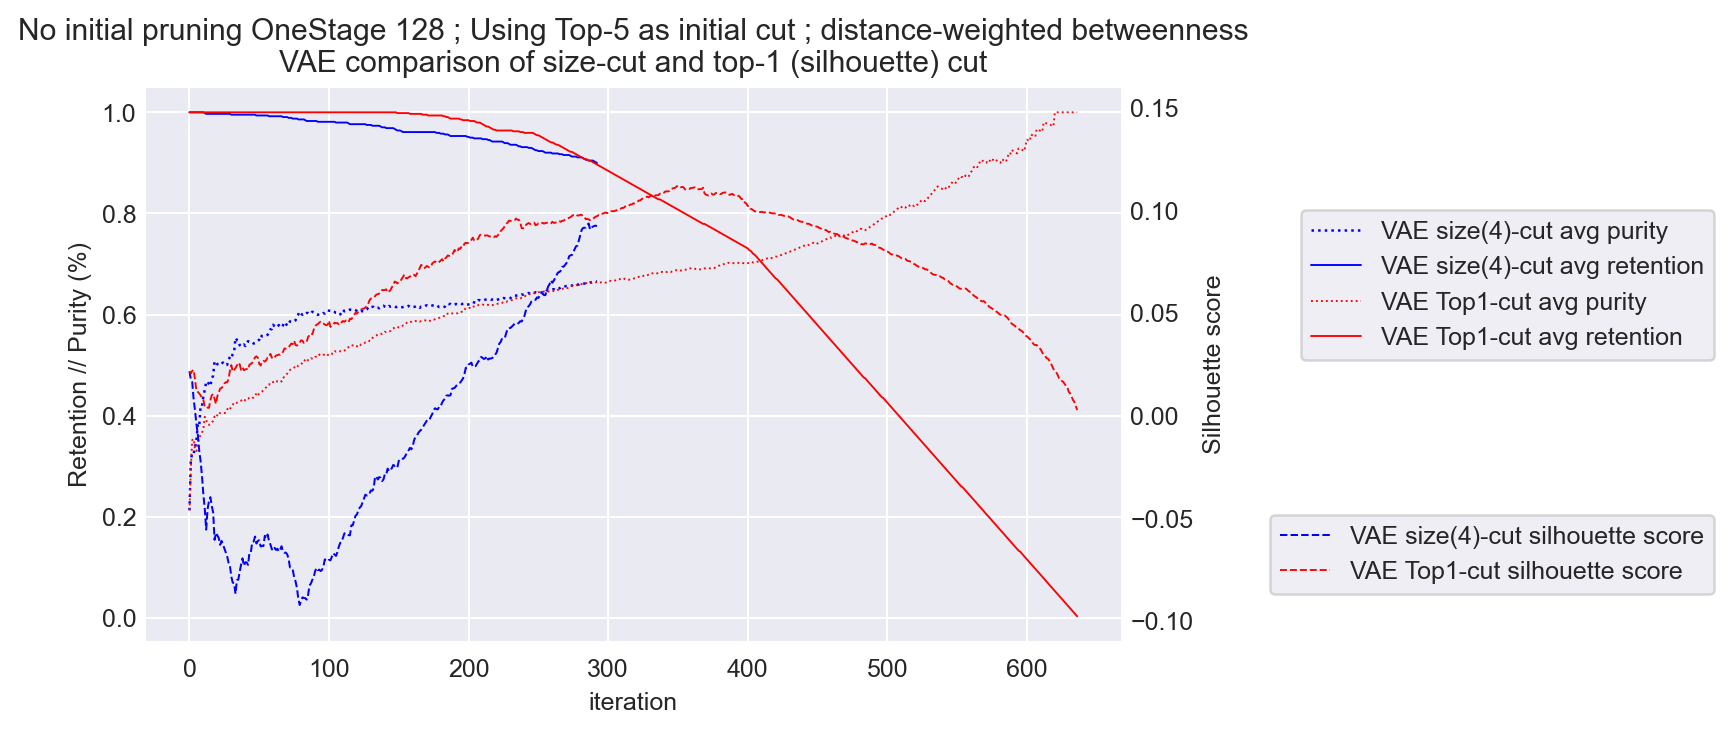

In [220]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning OneStage 128 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_os128)), it_purities_os128, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_os128)), it_rets_os128, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_os128)), it_scores_os128, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_os128)), sh_purities_os128, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_os128)), sh_rets_os128, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_os128)), sh_scores_os128, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_os128_silhouette.png', dpi=150, bbox_inches='tight')


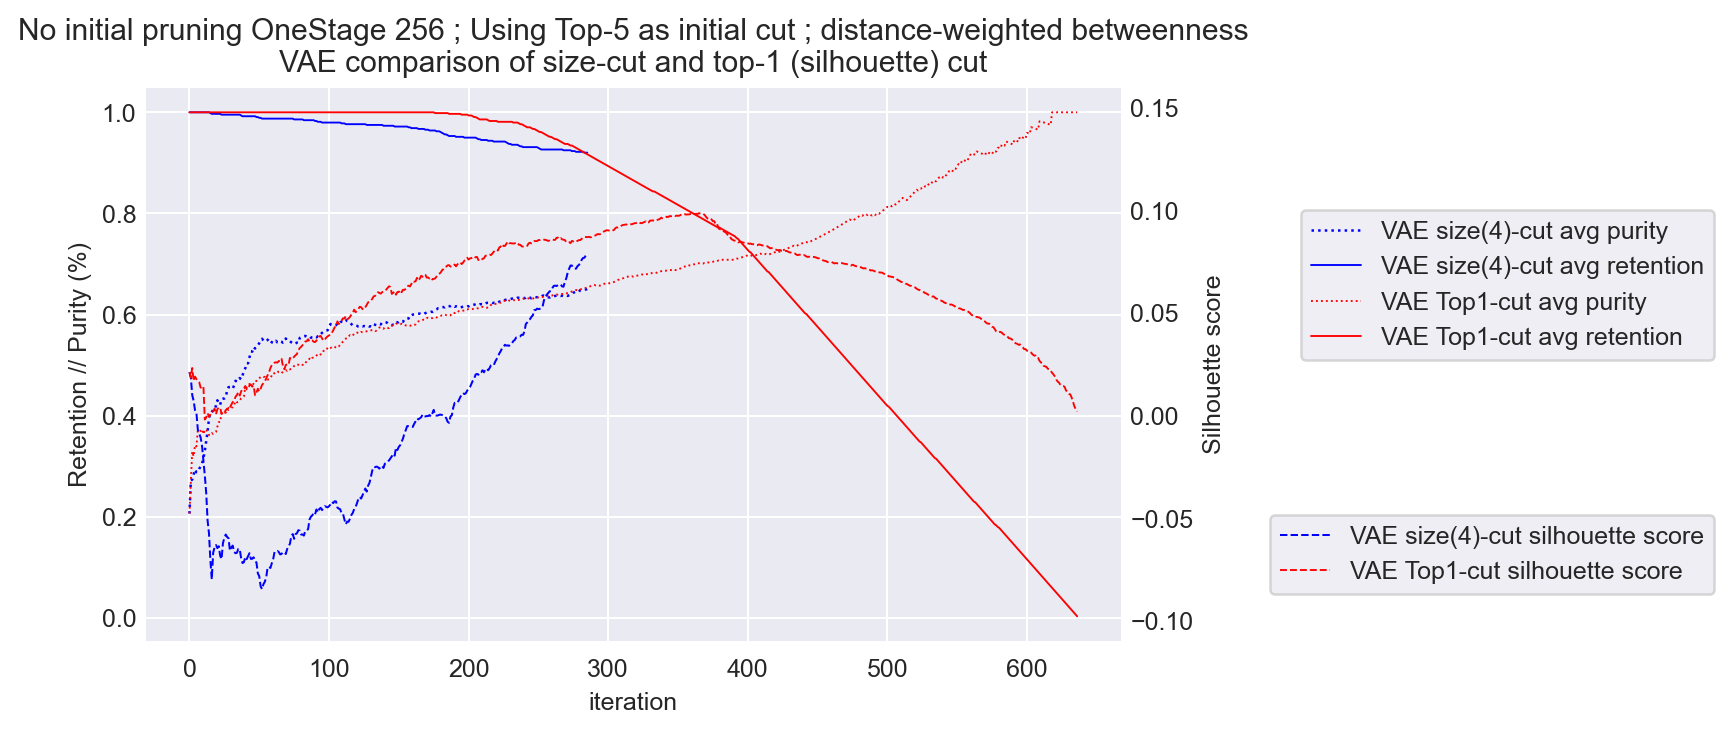

In [221]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning OneStage 256 ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_os256)), it_purities_os256, lw=1, ls=':', c='b',
       label='VAE size(4)-cut avg purity')
a.plot(range(len(it_rets_os256)), it_rets_os256, lw=.75, ls='-', c='b',
       label='VAE size(4)-cut avg retention')
a2.plot(range(len(it_scores_os256)), it_scores_os256, lw=.8, ls='--', c='b',
       label='VAE size(4)-cut silhouette score')

a.plot(range(len(sh_purities_os256)), sh_purities_os256, lw=.75, ls=':', c='r',
       label='VAE Top1-cut avg purity')
a.plot(range(len(sh_rets_os256)), sh_rets_os256, lw=.75, ls='-', c='r',
       label='VAE Top1-cut avg retention')
a2.plot(range(len(sh_scores_os256)), sh_scores_os256, lw=.75, ls='--', c='r',
       label='VAE Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_os256_silhouette.png', dpi=150, bbox_inches='tight')


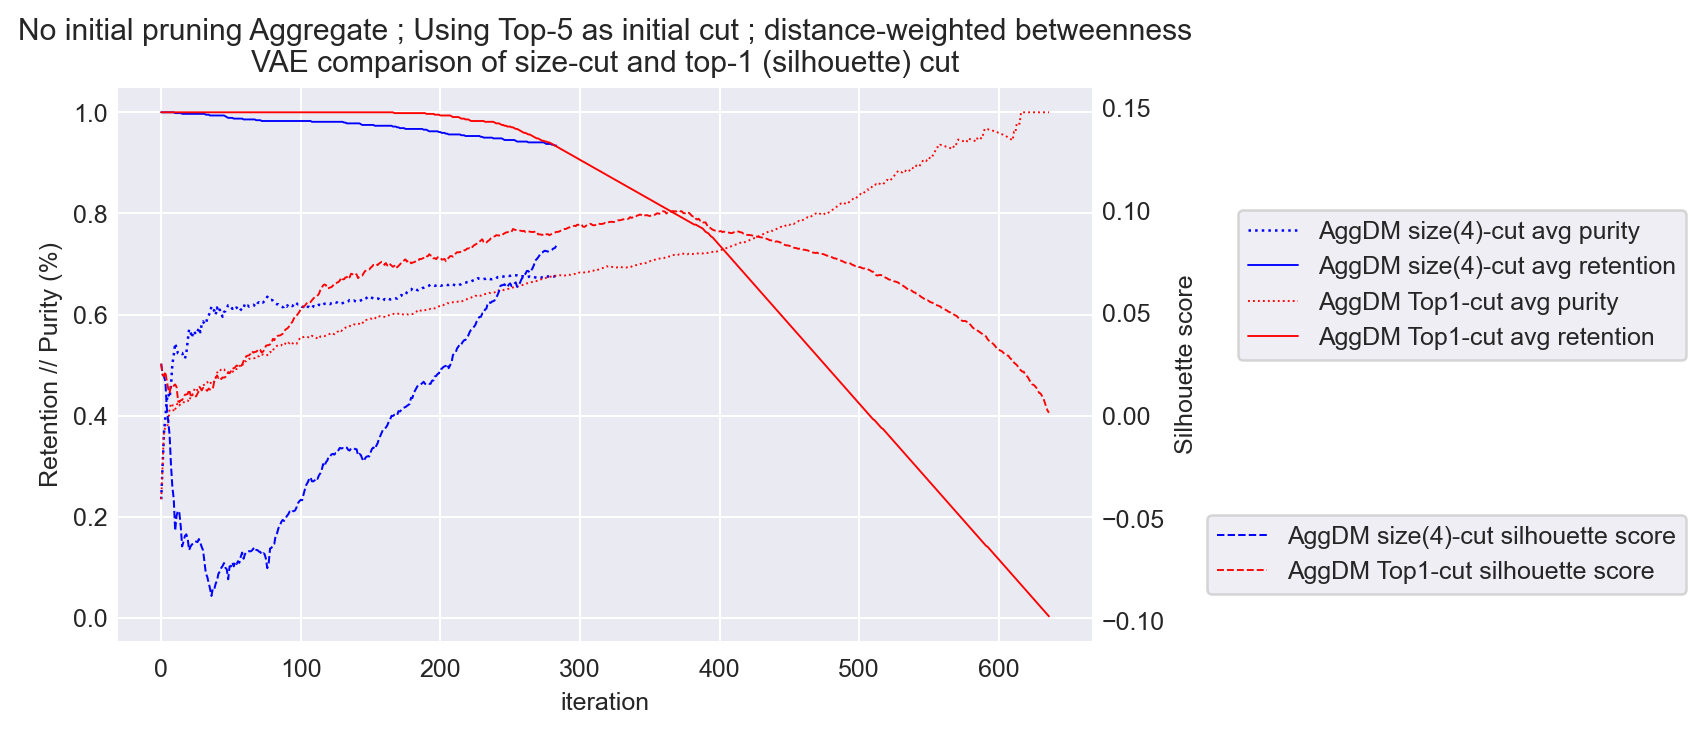

In [222]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning Aggregate ; Using Top-5 as initial cut ; distance-weighted betweenness\nVAE comparison of size-cut and top-1 (silhouette) cut')
a.plot(range(len(it_purities_agg)), it_purities_agg, lw=1, ls=':', c='b',
       label='AggDM size(4)-cut avg purity')
a.plot(range(len(it_rets_agg)), it_rets_agg, lw=.75, ls='-', c='b',
       label='AggDM size(4)-cut avg retention')
a2.plot(range(len(it_scores_agg)), it_scores_agg, lw=.8, ls='--', c='b',
       label='AggDM size(4)-cut silhouette score')

a.plot(range(len(sh_purities_agg)), sh_purities_agg, lw=.75, ls=':', c='r',
       label='AggDM Top1-cut avg purity')
a.plot(range(len(sh_rets_agg)), sh_rets_agg, lw=.75, ls='-', c='r',
       label='AggDM Top1-cut avg retention')
a2.plot(range(len(sh_scores_agg)), sh_scores_agg, lw=.75, ls='--', c='r',
       label='AggDM Top1-cut silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.8))
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_agg_silhouette.png', dpi=150, bbox_inches='tight')


### retpur curves

In [223]:
# Identify best point (based on Silhouette score) for each of the 4 conditions and add them as scatter points
best_sh_ts128 = sh_rets_ts128[np.argmax(sh_scores_ts128)], sh_purities_ts128[np.argmax(sh_scores_ts128)]
best_it_ts128 = it_rets_ts128[np.argmax(it_scores_ts128)], it_purities_ts128[np.argmax(it_scores_ts128)]
best_sh_os128 = sh_rets_os128[np.argmax(sh_scores_os128)], sh_purities_os128[np.argmax(sh_scores_os128)]
best_it_os128 = it_rets_os128[np.argmax(it_scores_os128)], it_purities_os128[np.argmax(it_scores_os128)]
best_sh_os256 = sh_rets_os256[np.argmax(sh_scores_os256)], sh_purities_os256[np.argmax(sh_scores_os256)]
best_it_os256 = it_rets_os256[np.argmax(it_scores_os256)], it_purities_os256[np.argmax(it_scores_os256)]
best_sh_agg = sh_rets_agg[np.argmax(sh_scores_agg)], sh_purities_agg[np.argmax(sh_scores_agg)]
best_it_agg = it_rets_agg[np.argmax(it_scores_agg)], it_purities_agg[np.argmax(it_scores_agg)]
best_tbcr_sh = tbcr_sh_rets[np.argmax(tbcr_sh_scores)], tbcr_sh_purities[np.argmax(tbcr_sh_scores)]
best_tbcr_it = tbcr_it_rets[np.argmax(tbcr_it_scores)], tbcr_it_purities[np.argmax(tbcr_it_scores)]
best_tcrdist_sh = tcrdist_sh_rets[np.argmax(tcrdist_sh_scores)], tcrdist_sh_purities[np.argmax(tcrdist_sh_scores)]
best_tcrdist_it = tcrdist_it_rets[np.argmax(tcrdist_it_scores)], tcrdist_it_purities[np.argmax(tcrdist_it_scores)]



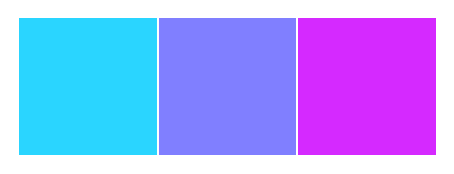

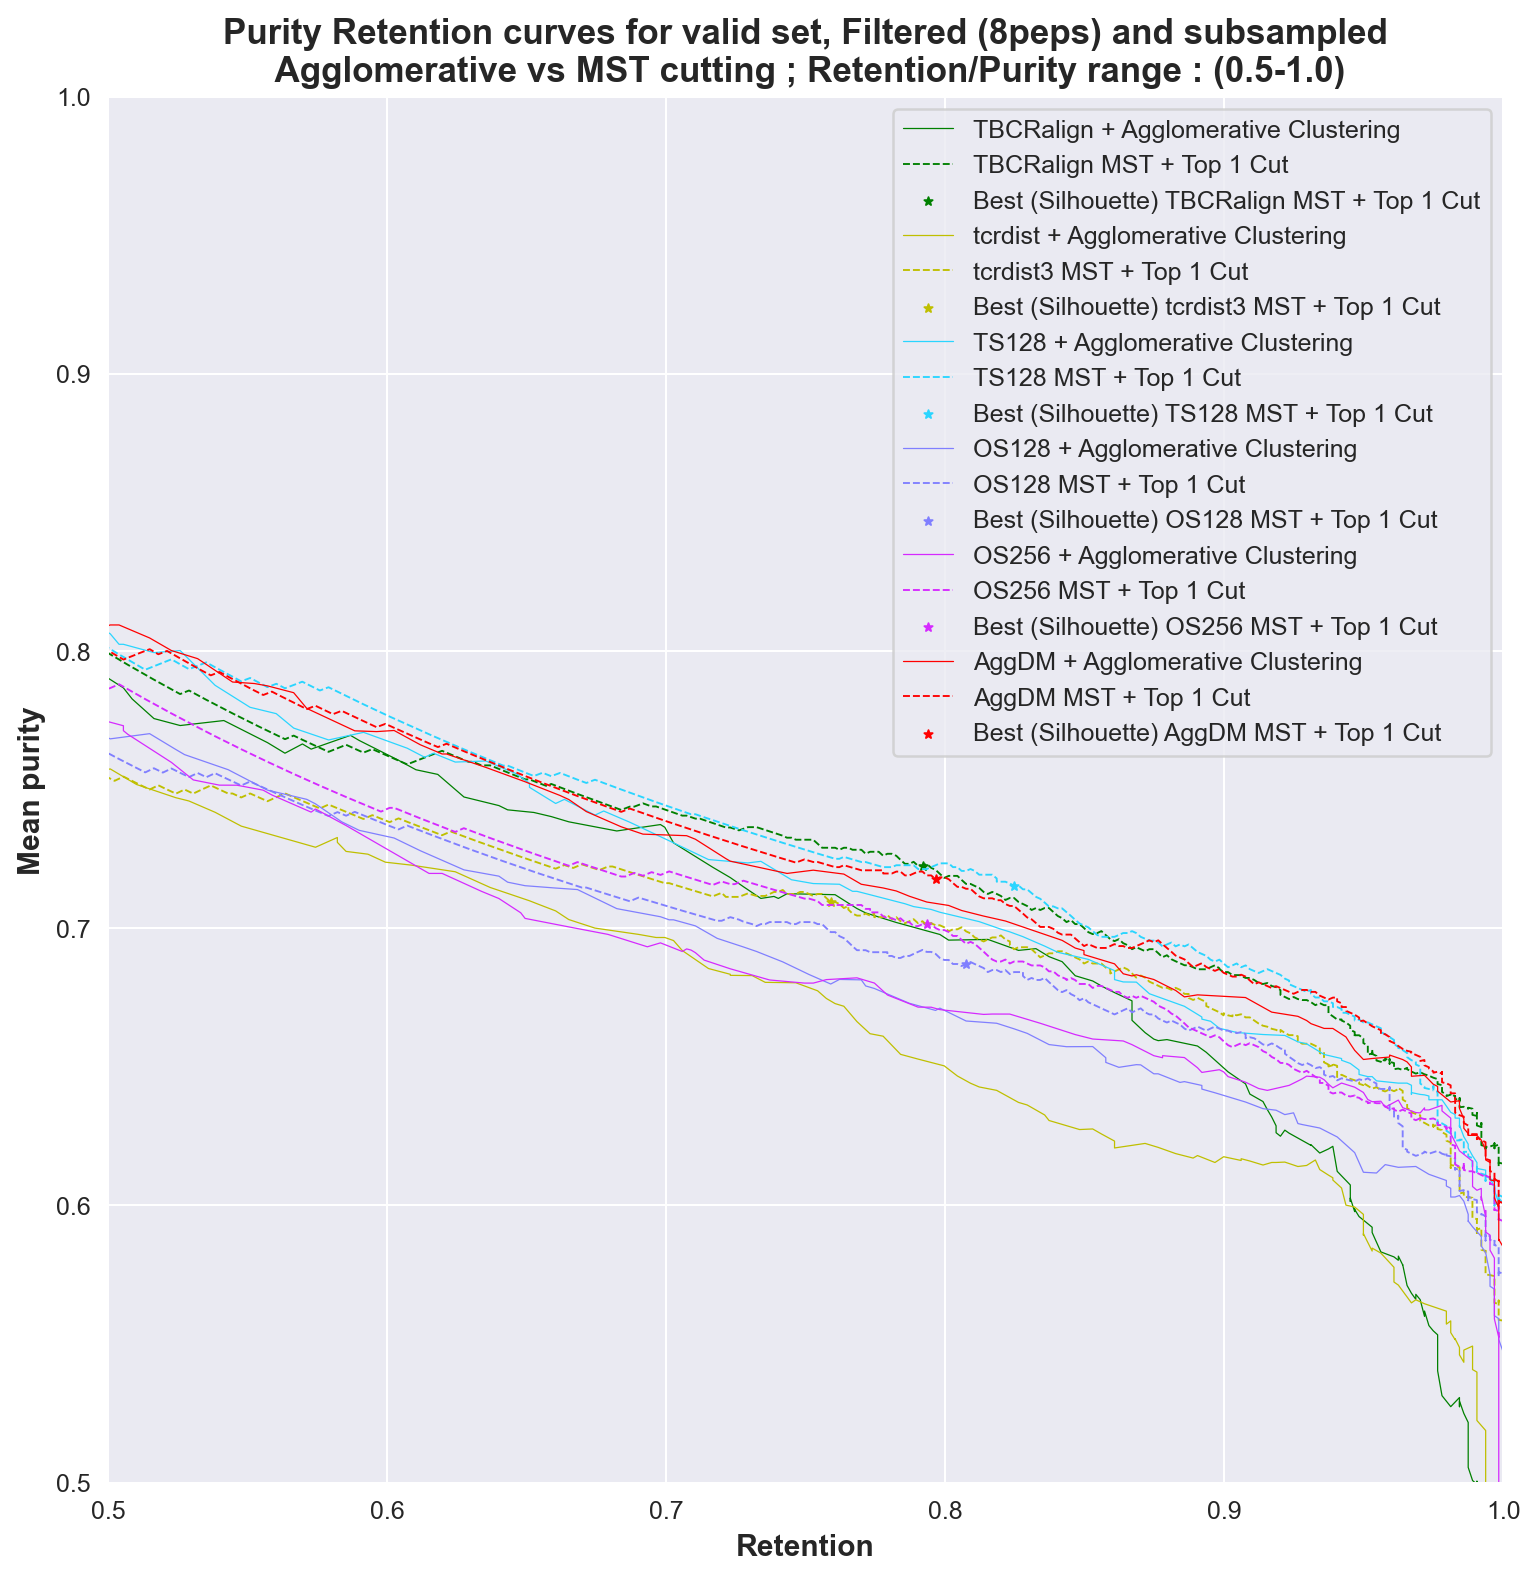

In [224]:
palette=get_palette('cool', 3)
sns.palplot(palette)
c_ts128 = palette[0]
c_os128 = palette[1]
c_os256 = palette[2]
c_agg = 'r'
c_tbcr='g'
c_tcrdist='y'
f,a = plt.subplots(1,1, figsize=(10, 10))
lw=.75
marker_size=12
marker='*'
# TBCRalign
a.plot(tbcr_cluster_testset['retention'].values[1:-1], tbcr_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TBCRalign + Agglomerative Clustering', lw=0.5, ls='-', c=c_tbcr)
a.plot(tbcr_sh_rets, tbcr_sh_purities, label = 'TBCRalign MST + Top 1 Cut', lw = lw, ls='--', c=c_tbcr)
a.scatter(best_tbcr_sh[0], best_tbcr_sh[1], c=c_tbcr, label = 'Best (Silhouette) TBCRalign MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)

# tcrdist3
a.plot(tcrdist_cluster_testset['retention'].values[1:-1], tcrdist_cluster_testset['mean_purity'].values[1:-1], 
       label = 'tcrdist + Agglomerative Clustering', lw=0.5, ls='-', c=c_tcrdist)
a.plot(tcrdist_sh_rets, tcrdist_sh_purities, label = 'tcrdist3 MST + Top 1 Cut', lw = lw, ls='--', c=c_tcrdist)
a.scatter(best_tcrdist_sh[0], best_tcrdist_sh[1], c=c_tcrdist, label = 'Best (Silhouette) tcrdist3 MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)


# TS128
a.plot(ts128_cluster_testset['retention'].values[1:-1], ts128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_ts128)
a.plot(sh_rets_ts128, sh_purities_ts128, label = 'TS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_ts128)
a.scatter(best_sh_ts128[0], best_sh_ts128[1], c=c_ts128, label = 'Best (Silhouette) TS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS128
a.plot(os128_cluster_testset['retention'].values[1:-1], os128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os128)

a.plot(sh_rets_os128, sh_purities_os128, label = 'OS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_os128)
a.scatter(best_sh_os128[0], best_sh_os128[1], c=c_os128, label = 'Best (Silhouette) OS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS256
a.plot(os256_cluster_testset['retention'].values[1:-1], os256_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS256 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os256)

a.plot(sh_rets_os256, sh_purities_os256, label = 'OS256 MST + Top 1 Cut', lw = lw, ls='--', c=c_os256)
a.scatter(best_sh_os256[0], best_sh_os256[1], c=c_os256, label = 'Best (Silhouette) OS256 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# Aggregated
a.plot(agg_cluster_testset['retention'].values[1:-1], agg_cluster_testset['mean_purity'].values[1:-1], 
       label = 'AggDM + Agglomerative Clustering', lw=0.5, ls='-', c=c_agg)

a.plot(sh_rets_agg, sh_purities_agg, label = 'AggDM MST + Top 1 Cut', lw = lw, ls='--', c=c_agg)
a.scatter(best_sh_agg[0], best_sh_agg[1], c=c_agg, label = 'Best (Silhouette) AggDM MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for valid set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting ; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}_retpur_curves.png', dpi=200, bbox_inches='tight')

# Leiden

## Do intervals

In [92]:
import random
seed=1
random.seed(seed)
# See TCRBase detour for exp_filt
print(exp_filt)
df = exp17.query('peptide in @exp_filt')
testset_subsample = []
validset_subsample = []
for p in exp_filt:
    tmp_test = df.query('peptide==@p')
    testset_subsample.append(tmp_test.sample(min(len(tmp_test), random.randint(70,90)), random_state=seed))
    tmp_valid = df.query('peptide==@p')
    validset_subsample.append(tmp_valid.sample(min(len(tmp_valid), random.randint(70,90)), random_state=seed))
    
test_df = pd.concat(testset_subsample)
test_idx = test_df['raw_index'].unique()
test_df.groupby('peptide').count()
valid_df = pd.concat(validset_subsample)
valid_idx = valid_df['raw_index'].unique()
valid_df.groupby('peptide').count()

Index(['ELAGIGILTV', 'RAKFKQLL', 'GILGFVFTL', 'YLQPRTFLL', 'TTDPSFLGRY',
       'SPRWYFYYL', 'KLGGALQAK', 'AVFDRKSDAK'],
      dtype='object', name='peptide')


Unnamed: 0.1  Unnamed: 0  A1  A2  A3  B1  B2  B3  allele  \
peptide                                                                
AVFDRKSDAK            83          83  83  83  83  83  83  83      83   
ELAGIGILTV            88          88  88  88  88  88  88  88      88   
GILGFVFTL             85          85  85  85  85  85  85  85      85   
KLGGALQAK             70          70  70  70  70  70  70  70      70   
RAKFKQLL              78          78  78  78  78  78  78  78      78   
SPRWYFYYL             73          73  73  73  73  73  73  73      73   
TTDPSFLGRY            82          82  82  82  82  82  82  82      82   
YLQPRTFLL             85          85  85  85  85  85  85  85      85   

            partition  binder  origin  original_peptide  raw_index  reference  \
peptide                                                                         
AVFDRKSDAK         83      83      83                83         83         83   
ELAGIGILTV         88      88      88                88         88         88   
GILGFVFTL          85      85      85                85         85         85   
KLGGALQAK          70      70      70                70         70         70   
RAKFKQLL           78      78      78                78         78         78   
SPRWYFYYL          73      73      73                73         73         73   
TTDPSFLGRY         82      82      82                82         82         82   
YLQPRTFLL          85      85      85                85         85         85   

            source_organism  input_type  db  
peptide                                      
AVFDRKSDAK                0          83  83  
ELAGIGILTV               14          88  88  
GILGFVFTL                29          85  85  
KLGGALQAK                 0          70  70  
RAKFKQLL                  0          78  78  
SPRWYFYYL                73          73  73  
TTDPSFLGRY               82          82  82  
YLQPRTFLL                85          85  85

In [147]:
# Best model picked on validation performance
model = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                        '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                        map_location='cpu')
latent_test = get_latent_df(model, test_df)
latent_valid = get_latent_df(model, valid_df)
dm_test, values_test, feats_test, labels_test, enc_labels_test, lab_enc_test = get_distances_labels_from_latent(latent_test, index_col='raw_index')
dm_valid, values_valid, feats_valid, labels_valid, enc_labels_valid, lab_enc_valid = get_distances_labels_from_latent(latent_valid, index_col='raw_index')
# re-get the baseline and re-filter based on the subset test set
dm_tbcr_test = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0).query('raw_index in @test_idx')
dm_tcrdist_test = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0).query('raw_index in @test_idx')
dm_tbcr_valid = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0).query('raw_index in @valid_idx')
dm_tcrdist_valid = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/tcrdist3_distmatrix_140peps_new_labeled.csv', index_col=0).query('raw_index in @valid_idx')
# Resort it just so that we can re-use the labels and indices in the same order
dm_tbcr_test, values_tbcr_test = resort_baseline(dm_tbcr_test, dm_test, 'raw_index')
dm_tcrdist_test, values_tcrdist_test = resort_baseline(dm_tcrdist_test, dm_test, 'raw_index')
dm_tbcr_valid, values_tbcr_valid = resort_baseline(dm_tbcr_valid, dm_valid, 'raw_index')
dm_tcrdist_valid, values_tcrdist_valid = resort_baseline(dm_tcrdist_valid, dm_valid, 'raw_index')


<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
Reloading best model:
epoch: 5000
total: 0.2245618547955234
reconstruction: 0.06651628997370614
kld: 0.0
triplet: 0.0
BCE: 0.15804556644786044
seq_accuracy: 0.9947178959846497
pos_accuracy: 0.9971309900283813
auc: 0.7345
auc_01: 0.62808
auc_01_real: 0.29334
precision: 0.49085
recall: 0.3692
accuracy: 0.83052
AP: 0.4586


In [179]:
import igraph as ig
import leidenalg
from functools import partial
from joblib import Parallel, delayed
def get_leiden_single(dist_threshold, values, dist_matrix):
    thresholded = values<dist_threshold# quantile
    thresholded = thresholded * values
    t_graph = nx.Graph(thresholded)
    labels = dist_matrix['peptide'].values
    raw_indices = dist_matrix['raw_index'].values
    
    for i, node in enumerate(t_graph.nodes()):
        t_graph.nodes[node]['peptide'] = labels[i]
        t_graph.nodes[node]['raw_index'] = raw_indices[i]
        
    # Get igGraph
    edges = [(u,v, data['weight']) for u,v ,data in t_graph.edges(data=True)]
    nodes = [(n, data) for n, data in t_graph.nodes(data=True)]
    t_ig_graph = ig.Graph.from_networkx(t_graph)
    # Adding node information
    for idx, (node, attr) in enumerate(nodes):
        t_ig_graph.vs[idx]["name"] = node
        t_ig_graph.vs[idx]["peptide"] = attr['peptide']
        t_ig_graph.vs[idx]["raw_index"] = attr['raw_index']
    try:
        partition = leidenalg.find_partition(t_ig_graph, leidenalg.ModularityVertexPartition,
                                             n_iterations=5, weights='weight')
        # print(max(partition.membership))
        # print(partition.membership)
        q_resdf = []
        # Print node attributes with their community assignments
        for idx, node in enumerate(t_ig_graph.vs):
            # print(f"Node {node['name']} (peptide: {node['peptide']}) is in community {partition.membership[idx]}")
            q_resdf.append({'node':node['name'], 'label':node['peptide'], 'pred':partition.membership[idx]})
        q_resdf=pd.DataFrame(q_resdf)
        q_results=[]
        for p in q_resdf.pred.unique():
            tmp = q_resdf.query('pred==@p')
            d=tmp.groupby('label').agg(count=('node','count')).to_dict()['count']
            sorted_d={k:v for k,v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
            top_label = list(sorted_d.keys())[0]
            purity = sorted_d[top_label] / sum(sorted_d.values())
            q_results.append({'pred':p, 'label':top_label, 'purity':purity, 'cluster_size':sum(sorted_d.values())})
        q_results = pd.DataFrame(q_results).sort_values(['cluster_size','purity'], ascending=False).rename(columns={'label':'majority_label'}).sort_values('majority_label')
        try:
            silhouette = silhouette_score(values, partition.membership, metric='precomputed')
        except:
            silhouette = np.nan
        # excep
        
        # print(round(dist_threshold, 3), '\t---\t', round(q_results.query('cluster_size>1').purity.mean(), 4), '\t---\t', round(q_results.query('cluster_size>1').cluster_size.sum()/len(t_graph),4))
        return {'threshold':dist_threshold, 
                'mean_purity':q_results.query('cluster_size>1').purity.mean(),
                'retention':q_results.query('cluster_size>1').cluster_size.sum()/len(values),
                'silhouette':silhouette}
    except:
        return {'threshold':dist_threshold,
                'mean_purity':np.nan, 'retention':np.nan, 'silhouette':np.nan}

def get_leiden_all(values, dist_matrix, n_points=500, n_jobs=8):
    threshold_range = tqdm(np.linspace(values[values!=0].min(), values.max(), n_points), position=0, leave=False)
    wrapper = partial(get_leiden_single, values=values, dist_matrix=dist_matrix)
    results = Parallel(n_jobs)(delayed(wrapper)(dist_threshold=t) for t in threshold_range)
    return pd.DataFrame(results)

In [180]:
leiden_test = get_leiden_all(values_test, dm_test).assign(dist_matrix='ts128', method='leiden', dataset='8peps', partition='test', fold=1)
leiden_valid = get_leiden_all(values_valid, dm_valid).assign(dist_matrix='ts128', method='leiden', dataset='8peps', partition='valid', fold=0)
leiden_tbcr_test = get_leiden_all(values_tbcr_test, dm_tbcr_test).assign(dist_matrix='tbcr', method='leiden', dataset='8peps', partition='test', fold=1)
leiden_tbcr_valid = get_leiden_all(values_tbcr_valid, dm_tbcr_valid).assign(dist_matrix='tbcr', method='leiden', dataset='8peps', partition='valid', fold=0)
leiden_tcrdist_test = get_leiden_all(values_tcrdist_test, dm_tcrdist_test).assign(dist_matrix='tcrdist', method='leiden', dataset='8peps', partition='test', fold=1)
leiden_tcrdist_valid = get_leiden_all(values_tcrdist_valid, dm_tcrdist_valid).assign(dist_matrix='tcrdist', method='leiden', dataset='8peps', partition='valid', fold=0)

In [326]:
test_clustering = pd.concat([test_clustering, leiden_test, leiden_tbcr_test, leiden_tcrdist_test]).replace({'MST_size_cut':'MST_top1_cut'})
valid_clustering = pd.concat([valid_clustering.query('method!="leiden"'), leiden_valid, leiden_tbcr_valid, leiden_tcrdist_valid]).replace({'MST_size_cut':'MST_top1_cut'})

In [327]:
test_clustering.head()

threshold  n_cluster  n_singletons  n_cluster_over_70p  mean_purity  \
0    0.07073        0.0         639.0                 0.0          NaN   
1    0.07341        1.0         637.0                 1.0          1.0   
2    0.07608        1.0         637.0                 1.0          1.0   
3    0.07876        1.0         637.0                 1.0          1.0   
4    0.08144        1.0         637.0                 1.0          1.0   

   min_purity  max_purity  mean_coherence  min_coherence  max_coherence  ...  \
0         NaN         NaN             NaN            NaN            NaN  ...   
1         1.0         1.0        0.070737       0.070737       0.070737  ...   
2         1.0         1.0        0.070737       0.070737       0.070737  ...   
3         1.0         1.0        0.070737       0.070737       0.070737  ...   
4         1.0         1.0        0.070737       0.070737       0.070737  ...   

   silhouette   ch_index  db_index       ARI  retention  dist_matrix  \
0         NaN        NaN       NaN  0.000000    0.00000        ts128   
1    0.002623  35.495935   0.07852  0.000069    0.00313        ts128   
2    0.002623  35.495935   0.07852  0.000069    0.00313        ts128   
3    0.002623  35.495935   0.07852  0.000069    0.00313        ts128   
4    0.002623  35.495935   0.07852  0.000069    0.00313        ts128   

          method  dataset partition fold  
0  agglomerative    8peps      test    1  
1  agglomerative    8peps      test    1  
2  agglomerative    8peps      test    1  
3  agglomerative    8peps      test    1  
4  agglomerative    8peps      test    1  

[5 rows x 23 columns]

In [328]:
valid_clustering.head()

threshold  n_cluster  n_singletons  n_cluster_over_70p  mean_purity  \
0    0.09994        0.0         639.0                 0.0          NaN   
1    0.10250        1.0         637.0                 1.0          1.0   
2    0.10507        1.0         637.0                 1.0          1.0   
3    0.10763        1.0         637.0                 1.0          1.0   
4    0.11020        1.0         637.0                 1.0          1.0   

   min_purity  max_purity  mean_coherence  min_coherence  max_coherence  ...  \
0         NaN         NaN             NaN            NaN            NaN  ...   
1         1.0         1.0        0.099941       0.099941       0.099941  ...   
2         1.0         1.0        0.099941       0.099941       0.099941  ...   
3         1.0         1.0        0.099941       0.099941       0.099941  ...   
4         1.0         1.0        0.099941       0.099941       0.099941  ...   

   silhouette  ch_index  db_index       ARI  retention  dist_matrix  \
0         NaN       NaN       NaN  0.000000    0.00000        ts128   
1    0.001363  15.73498   0.11901  0.000069    0.00313        ts128   
2    0.001363  15.73498   0.11901  0.000069    0.00313        ts128   
3    0.001363  15.73498   0.11901  0.000069    0.00313        ts128   
4    0.001363  15.73498   0.11901  0.000069    0.00313        ts128   

          method  dataset partition fold  
0  agglomerative    8peps     valid    0  
1  agglomerative    8peps     valid    0  
2  agglomerative    8peps     valid    0  
3  agglomerative    8peps     valid    0  
4  agglomerative    8peps     valid    0  

[5 rows x 23 columns]

In [329]:
test_clustering.to_csv('../output/240618_NestedKCV_CNNVAE/240723_test_clustering.csv')
valid_clustering.to_csv('../output/240618_NestedKCV_CNNVAE/240723_valid_clustering.csv')

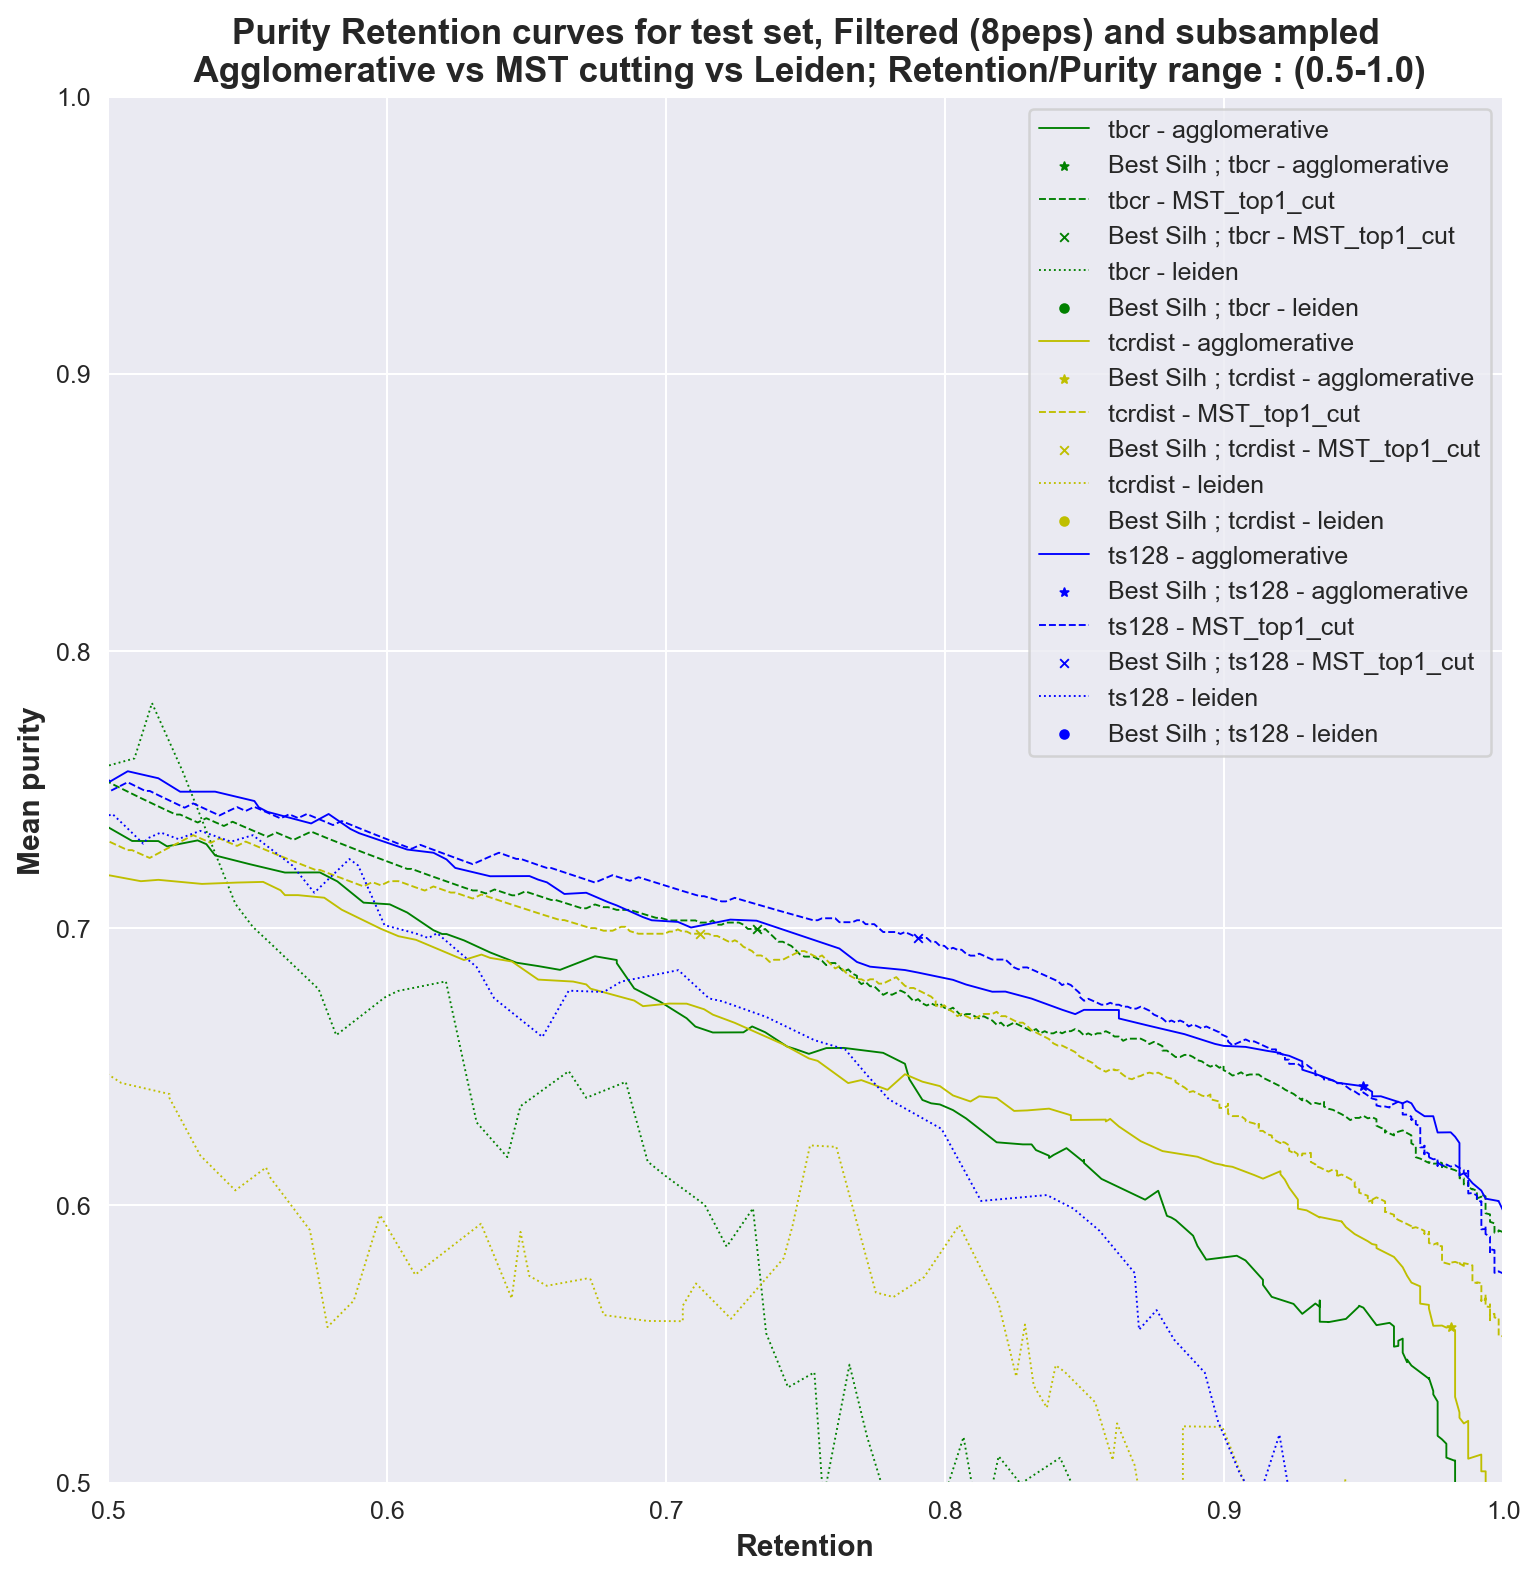

In [330]:
f,a = plt.subplots(1,1, figsize=(10,10))
lw=.75
marker_size=12
for dm, color in zip(['tbcr', 'tcrdist', 'ts128'], ['g', 'y', 'b']):
    for method, ls, marker in zip(['agglomerative', 'MST_top1_cut', 'leiden'], ['-', '--', ':'], ['*', 'x', 'o']):
        tmp = test_clustering.query('dist_matrix==@dm and method==@method')
        max_id = tmp.iloc[tmp['silhouette'].argmax()]
        a.plot(tmp['retention'].values[1:-1], tmp['mean_purity'].values[1:-1], ls=ls, lw=lw, c=color, label= f'{dm} - {method}')
        a.scatter(max_id['retention'], max_id['mean_purity'], c=color, s=marker_size, marker=marker,
                  lw=lw, label=f'Best Silh ; {dm} - {method}')

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for test set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting vs Leiden; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/8peps_test_subsampled_WithLeiden_retpur_curves.png', dpi=200, bbox_inches='tight')

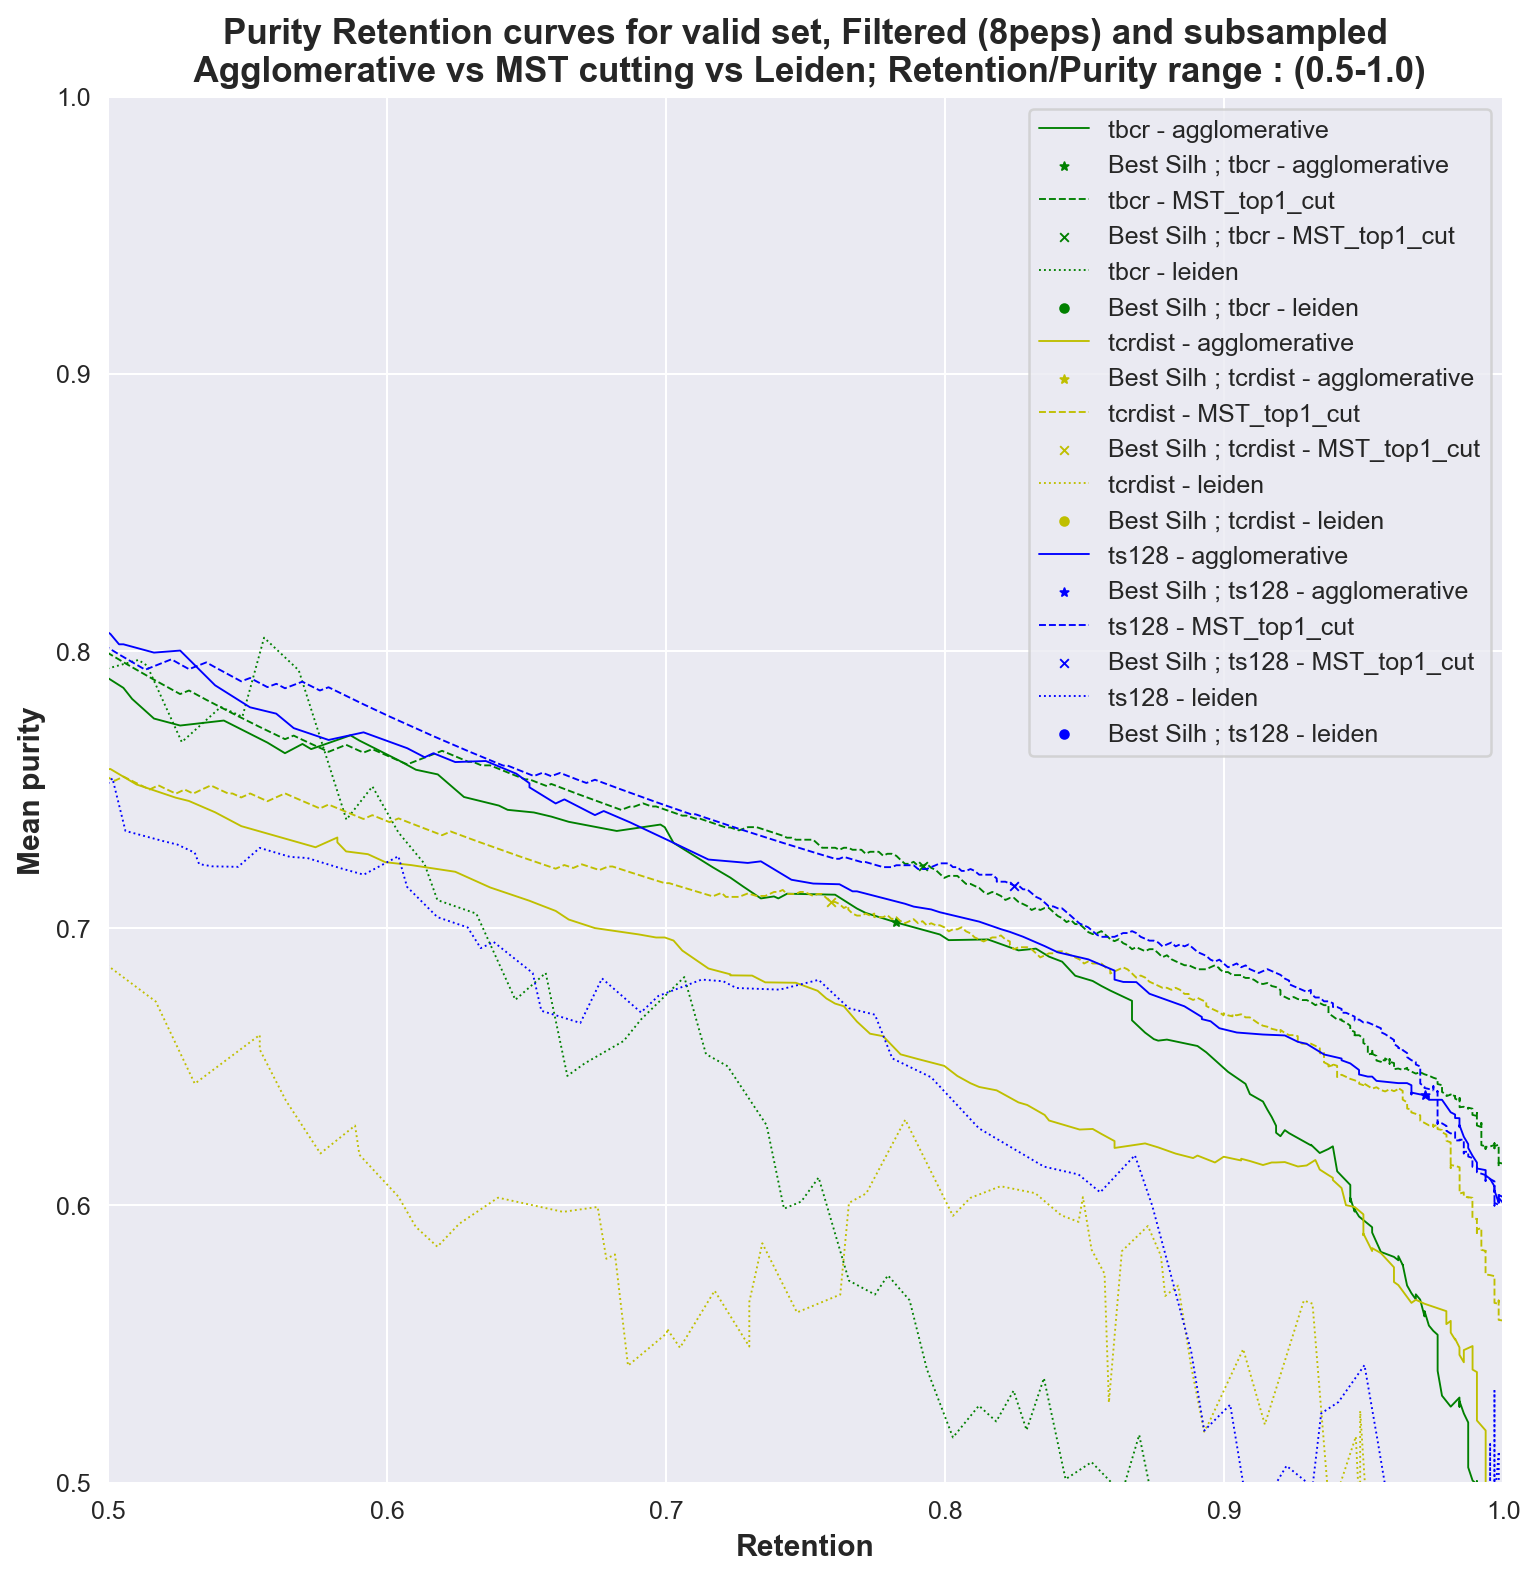

In [331]:
f,a = plt.subplots(1,1, figsize=(10,10))
lw=.75
marker_size=12
for dm, color in zip(['tbcr', 'tcrdist', 'ts128'], ['g', 'y', 'b']):
    for method, ls, marker in zip(['agglomerative', 'MST_top1_cut', 'leiden'], ['-', '--', ':'], ['*', 'x', 'o']):
        tmp = valid_clustering.query('dist_matrix==@dm and method==@method')
        max_id = tmp.iloc[tmp['silhouette'].argmax()]
        a.plot(tmp['retention'].values[1:-1], tmp['mean_purity'].values[1:-1], ls=ls, lw=lw, c=color, label= f'{dm} - {method}')
        a.scatter(max_id['retention'], max_id['mean_purity'], c=color, s=marker_size, marker=marker,
                  lw=lw, label=f'Best Silh ; {dm} - {method}')

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for valid set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting vs Leiden; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)
f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/8peps_valid_subsampled_WithLeiden_retpur_curves.png', dpi=200, bbox_inches='tight')

In [ ]:

def create_mst_from_distance_matrix(distance_matrix, label_col='peptide', index_col='raw_index', algorithm='kruskal'):
    """
    Given a labelled distance matrix, create the Graph and minimum spanning tree associated
    Args:
        distance_matrix:
        label_col:
        index_col:
        algorithm:

    Returns:

    """
    distance_matrix = distance_matrix.copy(deep=True)
    indexing = [str(x) for x in distance_matrix.index] if type(
        distance_matrix.columns[0]) == str else distance_matrix.index
    values = distance_matrix[indexing].values
    labels = distance_matrix[label_col].values
    if index_col is not None:
        raw_indices = distance_matrix[index_col].values
    else:
        distance_matrix['raw_index'] = [f'seq_id_{i}' for i in range(len(distance_matrix))]
        raw_indices = distance_matrix['raw_index'].values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    G = nx.Graph(values)
    for i, node in enumerate(G.nodes()):
        G.nodes[node][label_col] = labels[i]
        G.nodes[node][index_col] = raw_indices[i]
    tree = nx.minimum_spanning_tree(G, algorithm=algorithm)
    # For now, return all values as they may be useful later for analysis
    return G, tree, distance_matrix, values, labels, encoded_labels, label_encoder, raw_indices


def prune_by_distance(tree, distance_threshold, prune_node=True, labels=None, label_key='peptide', verbose=False):
    """
    Given a minimum spanning tree, prune it based on a distance threshold
    Args:
        tree:
        distance_threshold:
        prune_node: Bool, remove nodes that have become isolated after edge-pruning
        labels:
        verbose:

    Returns:

    """
    tree_pruned = tree.copy()
    removed_edges = []
    removed_nodes = []
    for u, v in tree_pruned.edges():
        weight = tree_pruned.get_edge_data(u, v)['weight']
        if weight >= distance_threshold:  # assuming weight is a distance and not a similarity
            # If providing label, use it to get l1, l2 for the class check
            if labels is not None:
                l1 = labels[u]
                l2 = labels[v]
            # else, if label-key exists and the key is in the tree nodes attributes, use those
            elif label_key is not None and label_key in tree.nodes[0]:
                l1 = tree_pruned.nodes[u][label_key]
                l2 = tree_pruned.nodes[v][label_key]
            else:
                l1, l2 = np.nan, np.nan
            removed_edges.append((u, v, round(weight, 4), int(l1 == l2)))
            tree_pruned.remove_edge(u, v)
    if prune_node:
        removed_nodes = list(nx.isolates(tree_pruned))
        tree_pruned.remove_nodes_from(removed_nodes)

    if verbose:
        print(f'***\nbefore pruning : {len(tree.edges())} edges, {len(tree.nodes())} nodes\n***')
        print(f'***\nafter pruning : {len(tree_pruned.edges())} edges, {len(tree_pruned.nodes())} nodes\n***')
        print(len(removed_edges), 'removed edges',
              f'\n{np.array([x[3] for x in removed_edges]).mean():.2%} of the removed edges were actually same-class')

    return tree_pruned, removed_edges, removed_nodes


def get_color_map(distance_matrix, label_col='peptide', palette='tab10'):
    labels = distance_matrix[label_col].unique()
    color_map = {k: v for k, v in zip(sorted(np.unique(labels)), sns.color_palette(palette, len(np.unique(labels))))}
    return color_map


def plot_mst_spring(tree, color_map, title=None, figsize=(8, 8),
                    iterations=300, threshold=1e-5, scale=0.9, k=0.05, dim=2, seed=131):
    sns.set_style('darkgrid')
    # Visualize the graph and the minimum spanning tree
    f, a = plt.subplots(1, 1, figsize=figsize)
    pos = nx.spring_layout(tree, iterations=iterations, threshold=threshold, seed=seed, scale=scale, k=k, dim=dim)
    node_colors = [color_map[tree.nodes[node]['peptide']] for node in tree.nodes()]
    nx.draw_networkx_nodes(tree, pos, node_color=node_colors, node_size=52.5,
                           ax=a)  # nx.draw_networkx_edges(G, pos, edge_color="grey")
    nx.draw_networkx_labels(tree, pos, font_size=4, font_color='w', font_weight='semibold', font_family="monospace")
    nx.draw_networkx_edges(tree, pos, edge_color="k", width=0.75)
    # Create a legend
    legend_labels = {k: color_map[k] for k in sorted(color_map.keys())}  # Sorted keys for consistent order
    patches = [Patch(color=color, label=f'{label}') for label, color in legend_labels.items()]
    plt.legend(handles=patches, title='Node Classes', loc='best', borderaxespad=0.)
    # Find bottleneck score ; with centrality AND connectivity
    if title is not None:
        a.set_title(title)
    plt.axis("off")
    plt.show()

In [939]:
# Take G / MST
G, tree, dist_matrix, values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dm_ts128_testset)
list(tree.edges(data=True))[:5]
# Convert NetworkX graph to iGraph with node attributes
edges = [(u, v, data['weight']) for u, v, data in tree.edges(data=True)]
nodes = [(n, data) for n, data in tree.nodes(data=True)]

# Create an iGraph graph
t_ig_graph = ig.Graph.TupleList(edges, weights=True)

# Assign node attributes
for idx, (node, attr) in enumerate(nodes):
    t_ig_graph.vs[idx]["name"] = node
    t_ig_graph.vs[idx]["peptide"] = attr['peptide']
    t_ig_graph.vs[idx]["raw_index"] = attr['raw_index']

# Ensure weights and attributes are correctly assigned
# print("Edge weights in iGraph:", t_ig_graph.es["weight"])
# print("Node attributes in iGraph:", t_ig_graph.vs["peptide"], t_ig_graph.vs["raw_index"])

# Apply Leiden algorithm for community detection using edge weights
partition = leidenalg.find_partition(t_ig_graph, leidenalg.ModularityVertexPartition, n_iterations=30,
                                     weights=t_ig_graph.es["weight"])

# Print the results
# print("Number of communities:", max(partition.membership) + 1)
# print("Community membership of each node:", partition.membership)
resdf = []
# Print node attributes with their community assignments
for idx, node in enumerate(t_ig_graph.vs):
    # print(f"Node {node['name']} (peptide: {node['peptide']}) is in community {partition.membership[idx]}")
    resdf.append({'node':node['name'], 'label':node['peptide'], 'pred':partition.membership[idx]})
resdf=pd.DataFrame(resdf)
results=[]
for p in resdf.pred.unique():
    tmp = resdf.query('pred==@p')
    d=tmp.groupby('label').agg(count=('node','count')).to_dict()['count']
    sorted_d={k:v for k,v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
    top_label = list(sorted_d.keys())[0]
    purity = sorted_d[top_label] / sum(sorted_d.values())
    results.append({'pred':p, 'label':top_label, 'purity':purity, 'cluster_size':sum(sorted_d.values())})
# ig.plot(partition)
ll_results = pd.DataFrame(results).sort_values(['cluster_size','purity'], ascending=False).rename(columns={'label':'majority_label'}).sort_values('majority_label')
ll_results.query('cluster_size>1').purity.mean(), ll_results.query('cluster_size>1').cluster_size.sum() / len(dist_matrix)

(0.4171444888618721, 1.0)

# Check silhouette / MST cut with fake perfect or noisy distance matrix

In [607]:
# Do 400 datapoints and 5 classes with slightly different sizes
fake_labels = np.array([0]*75+[1]*60+[2]*70+[3]*115+[4]*80)
# Perf matrix is a binary matrix
perf_values = np.ones((400, 400))
# Noisy matrix simulates a distance matrix
noisy_values = np.ones((400, 400)) * np.random.uniform(low=0.9, high=1.25, size=(400,400))
new_values = copy.deepcopy(noisy_values)

for label in range(5):
    idxs = np.where(fake_labels==label)[0]
    size = idxs[-1]-idxs[0] +1
    for matrix in [perf_matrix, noisy_matrix]:
        perf_values[idxs[0]:idxs[-1]+1, idxs[0]:idxs[-1]+1] = 0.05
    
        noisy_values[idxs[0]:idxs[-1]+1, idxs[0]:idxs[-1]+1] = np.clip(np.random.normal(0.15, 0.1, size =(size,size)), 0.02575, 1)
        noisy_values = np.clip(noisy_values, 0,1.5)

In [608]:
import copy
# Create one more matrix which is "kinda" connected between the classes
fake_labels = np.array([0]*75+[1]*60+[2]*70+[3]*115+[4]*80)
new_values = copy.deepcopy(noisy_values)
# Use the perfect matrix as an indexing mask
a,b = np.where(perf_values!=0.05)
new_values[a, b] = np.clip(np.random.normal(0.25, 0.15, size=new_values[a,b].shape), 0.08, 0.7)
new_values = np.clip(new_values, a_min=-1.5, a_max=1.5)
new_values = (new_values * (1-np.eye(400,400))).round(4)

In [609]:
np.fill_diagonal(new_values, 0)
np.fill_diagonal(noisy_values, 0)
np.fill_diagonal(perf_values, 0)

Text(0.5, 1.0, 'noisier_values')

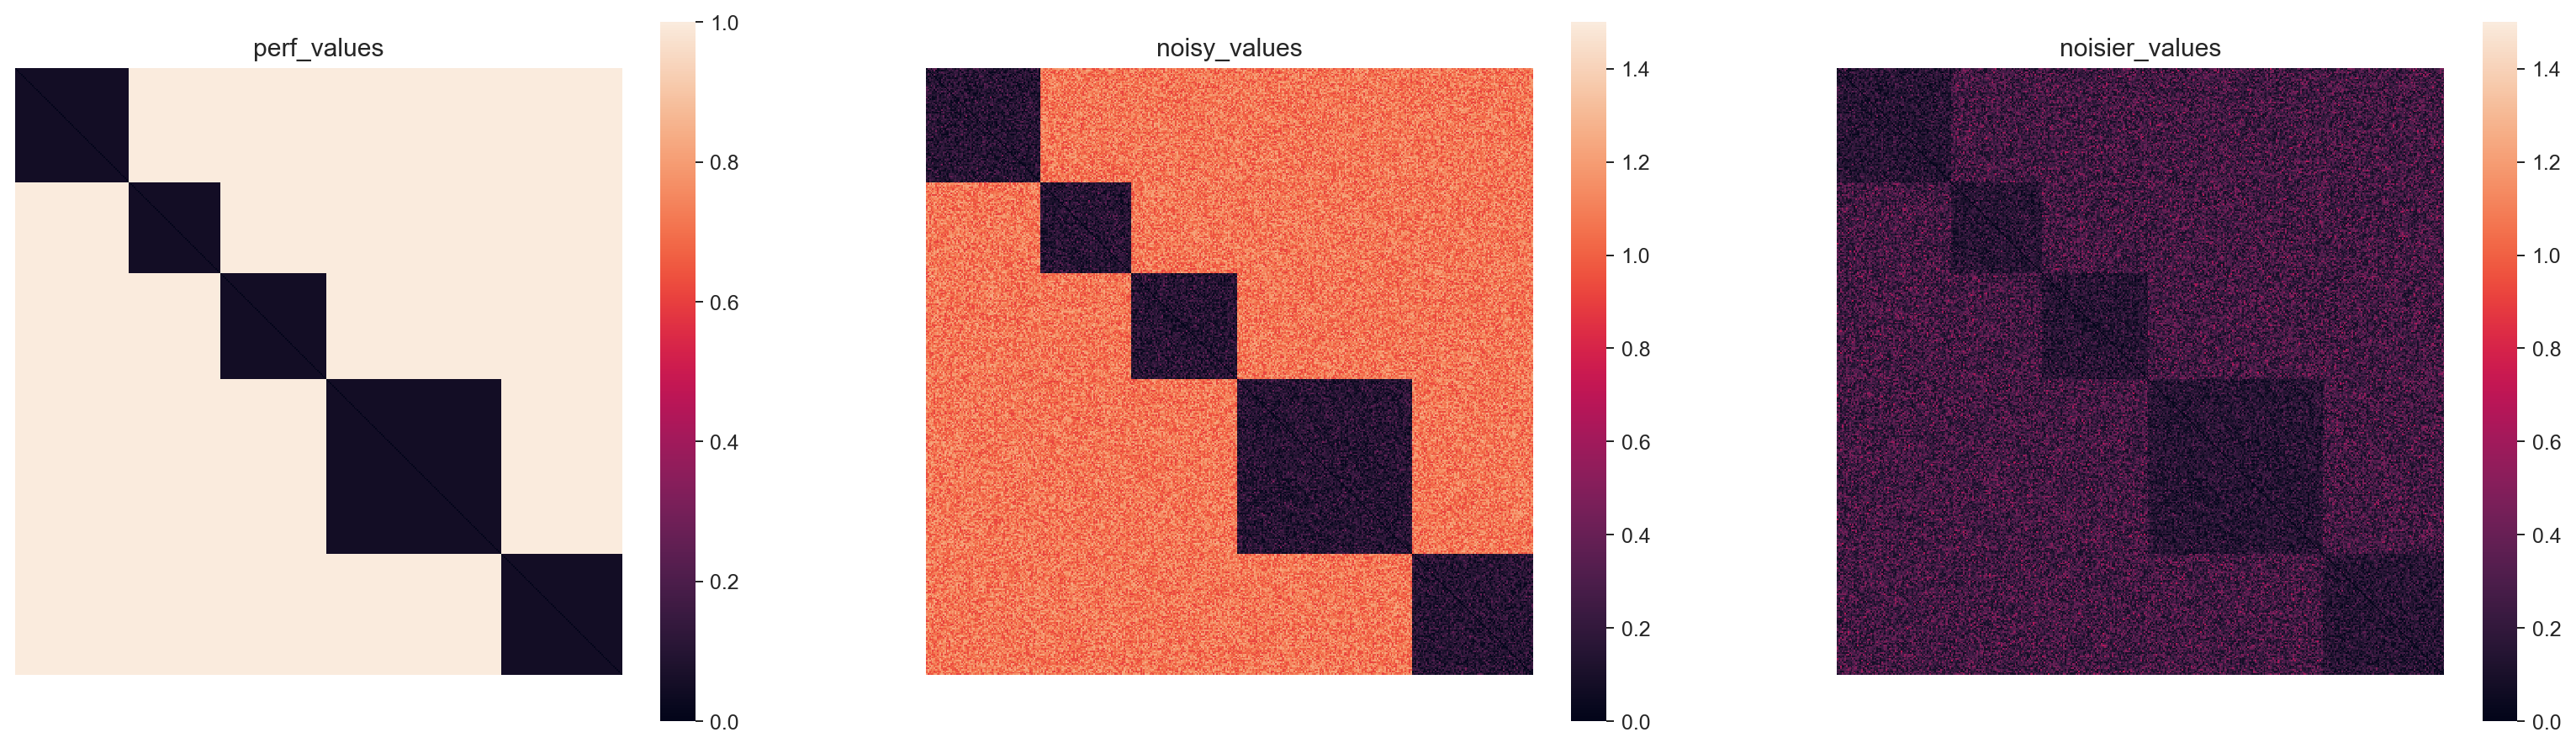

In [616]:
mapping = {k:v for k,v in zip(range(5), ['pep_a', 'pep_b', 'pep_c', 'pep_d', 'pep_e'])}
columns = [f'{mapping[x]}_{i}' for i,x in enumerate(fake_labels)]
noisy_matrix = pd.DataFrame(noisy_values, columns = columns, index=columns)
noisy_matrix['peptide'] = [mapping[x] for x in fake_labels]
noisy_matrix['raw_index'] = [f'seq_{i}' for i in range(len(noisy_matrix))]
perf_matrix = pd.DataFrame(perf_values, columns = columns, index=columns)
perf_matrix['peptide'] = [mapping[x] for x in fake_labels]
perf_matrix['raw_index'] = [f'seq_{i}' for i in range(len(perf_matrix))]
new_matrix = pd.DataFrame(new_values, columns = columns, index=columns)
new_matrix['peptide'] = [mapping[x] for x in fake_labels]
new_matrix['raw_index'] = [f'seq_{i}' for i in range(len(new_matrix))]
f,ax=plt.subplots(1,3, figsize=(22,6))
ax = ax.ravel()
sns.heatmap(perf_values,ax=ax[0],  square=True, xticklabels=False, yticklabels=False)
ax[0].set_title('perf_values')
sns.heatmap(noisy_values, ax=ax[1], square=True, vmax=1.5, vmin=0, xticklabels=False, yticklabels=False)
ax[1].set_title('noisy_values')
sns.heatmap(new_values, ax=ax[2], square=True, vmax=1.5, vmin=0, xticklabels=False, yticklabels=False)
ax[2].set_title('noisier_values')

In [601]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(fake_labels)
perf_values = perf_matrix.iloc[:len(perf_matrix), :len(perf_matrix)].values
noisy_values = noisy_matrix.iloc[:len(noisy_matrix), :len(noisy_matrix)].values

In [715]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G_perf, tree_perf, perf_matrix, perf_values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(perf_matrix, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
size_tree_cut_perf, size_subgraphs_perf, size_clusters_perf, \
size_edges_cut_perf, size_nodes_cut_perf, size_scores_perf, size_purities_perf, size_rets_perf = iterative_size_cut(perf_values, tree_perf, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

top1_tree_cut_perf, top1_subgraphs_perf, top1_clusters_perf, \
    top1_edges_cut_perf, top1_nodes_cut_perf, top1_scores_perf, top1_purities_perf, top1_rets_perf = iterative_topn_cut(perf_values, tree_perf, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in top1_clusters_perf]), np.mean([x['cluster_size'] for x in size_clusters_perf]))


Initial mean purity, silhouette score, retention
0.6404 0.4424 1.0
80.0 3.0


In [603]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G_noisy, tree_noisy, noisy_matrix, noisy_values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(noisy_matrix, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
size_tree_cut_noisy, size_subgraphs_noisy, size_clusters_noisy, size_edges_cut_noisy,\
        size_nodes_cut_noisy, size_scores_noisy, size_purities_noisy, size_rets_noisy = iterative_size_cut(noisy_values, tree_noisy, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

top1_tree_cut_noisy, top1_subgraphs_noisy, top1_clusters_noisy, \
    top1_edges_cut_noisy, top1_nodes_cut_noisy, top1_scores_noisy, top1_purities_noisy, top1_rets_noisy = iterative_topn_cut(noisy_values, tree_noisy,
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in top1_clusters_noisy]), np.mean([x['cluster_size'] for x in size_clusters_noisy]))


Initial mean purity, silhouette score, retention
0.4928 0.3535 1.0
80.0 2.702970297029703


In [611]:
# Two-Stage 128
# Same starting point as usual : Create a graph, mst, then prune it by distance (that might or might not just be useless)
G_new, tree_new, new_matrix, new_values, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(new_matrix, label_col='peptide',
                                                                                                                   index_col='raw_index', algorithm='kruskal')
# NO INITIAL PRUNING
size_tree_cut_new, size_subgraphs_new, size_clusters_new, size_edges_cut_new,\
        size_nodes_cut_new, size_scores_new, size_purities_new, size_rets_new = iterative_size_cut(new_values, tree_new, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

top1_tree_cut_new, top1_subgraphs_new, top1_clusters_new, \
    top1_edges_cut_new, top1_nodes_cut_new, top1_scores_new, top1_purities_new, top1_rets_new = iterative_topn_cut(new_values, tree_new,
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in top1_clusters_new]), np.mean([x['cluster_size'] for x in size_clusters_new]))


Initial mean purity, silhouette score, retention
0.6404 0.1927 1.0
80.0 2.5350877192982457


In [612]:
len(top1_clusters_perf), len(top1_clusters_new), len(top1_clusters_noisy)

(5, 5, 5)